In [109]:
# Define which data to load

path = 'D:\\work\\48h_output\\'
subfolder = 'max\\'
channel = '' # eg, "ch3\\"
ending = '.png'
output = '.\\'
f = open(output + "info2.txt", "a")
f.write(path + subfolder + channel+ "*" + ending)
f.close()

In [110]:
#Parameters 

IMAGE_SIZE = 540 #540 max
CHANNELS = 3
IMG_SHAPE = (IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.3


In [111]:
# Import Data from the csv

import csv
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

labels = []
images = []

#read csv file
with open(path + 'descriptor.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        #skip CNT for now
        if row[1] != 'CNT':
            images.append(path + subfolder + channel+ row[0] + ending) 
            labels.append(row[1])



In [112]:
#split in train and test data

train_size = 0.9; 
train_filenames, test_filenames, train_labels, test_labels = train_test_split(images, labels,train_size = train_size,random_state=42)

In [113]:
#create panda dataFrame for traindata
import pandas as pd
d_train= {'filename': train_filenames, 'class': train_labels}
df_train = pd.DataFrame(data=d_train)

#print info
print(df_train.groupby(['class']).size())
print(df_train)

class
CB    72
UT    66
dtype: int64
                           filename class
0    D:\work\48h_output\max\187.png    UT
1    D:\work\48h_output\max\012.png    CB
2    D:\work\48h_output\max\009.png    CB
3    D:\work\48h_output\max\182.png    UT
4    D:\work\48h_output\max\029.png    CB
..                              ...   ...
133  D:\work\48h_output\max\071.png    CB
134  D:\work\48h_output\max\174.png    UT
135  D:\work\48h_output\max\014.png    CB
136  D:\work\48h_output\max\160.png    UT
137  D:\work\48h_output\max\170.png    UT

[138 rows x 2 columns]


In [114]:
import pandas as pd

#create panda dataFrame for testdata
d_test = {'filename': test_filenames, 'class': test_labels}
df_test = pd.DataFrame(data=d_test)
df_test.groupby(['class']).size()

#print info
print(df_test.groupby(['class']).size())
print(df_test)

class
CB    7
UT    9
dtype: int64
                          filename class
0   D:\work\48h_output\max\015.png    CB
1   D:\work\48h_output\max\162.png    UT
2   D:\work\48h_output\max\220.png    UT
3   D:\work\48h_output\max\173.png    UT
4   D:\work\48h_output\max\177.png    UT
5   D:\work\48h_output\max\065.png    CB
6   D:\work\48h_output\max\018.png    CB
7   D:\work\48h_output\max\045.png    CB
8   D:\work\48h_output\max\036.png    CB
9   D:\work\48h_output\max\055.png    CB
10  D:\work\48h_output\max\153.png    UT
11  D:\work\48h_output\max\210.png    UT
12  D:\work\48h_output\max\019.png    CB
13  D:\work\48h_output\max\215.png    UT
14  D:\work\48h_output\max\154.png    UT
15  D:\work\48h_output\max\161.png    UT


In [115]:
from tensorflow.python.keras import backend as K 

K.clear_session()

In [116]:
#setup datagenerators

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

#create Image generator
datagen = ImageDataGenerator(
        rescale=1./255,  # set values to 0-1
        rotation_range=180, # rotation does not matter
        width_shift_range=0.2, # 20 % border
        height_shift_range=0.2,
        horizontal_flip=True, # flip does not matter
        vertical_flip=True, # flip does not matter
        fill_mode="nearest", 
        validation_split=VALIDATION_SPLIT) 


#create random seed
seed = random.seed()


#Note. not sure if these have to be reshuffled during iterations
#create generator for training data
train_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col="filename",
        y_col="class",
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        seed = seed,
        shuffle=True,
        color_mode = 'grayscale' if CHANNELS == 1 else 'rgb' )

#create generator for validation data
validation_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col="filename",
        y_col="class",
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed = seed,
        shuffle=True,
        color_mode = 'grayscale' if CHANNELS == 1 else 'rgb' )

print(train_generator.class_indices)
print(validation_generator.class_indices)

Found 97 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
{'CB': 0, 'UT': 1}
{'CB': 0, 'UT': 1}


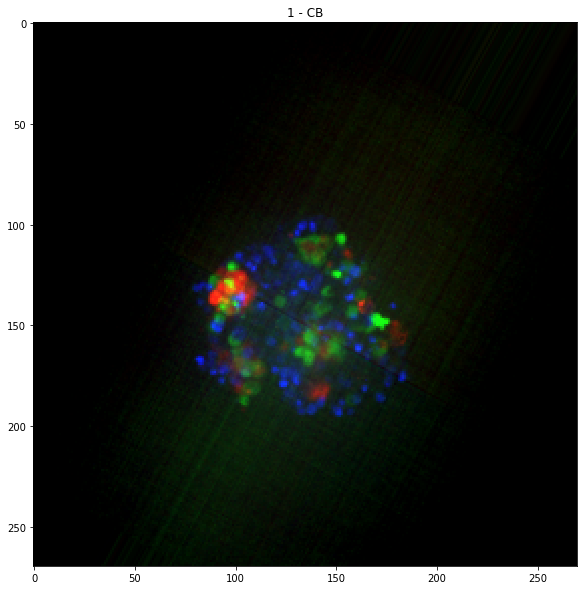

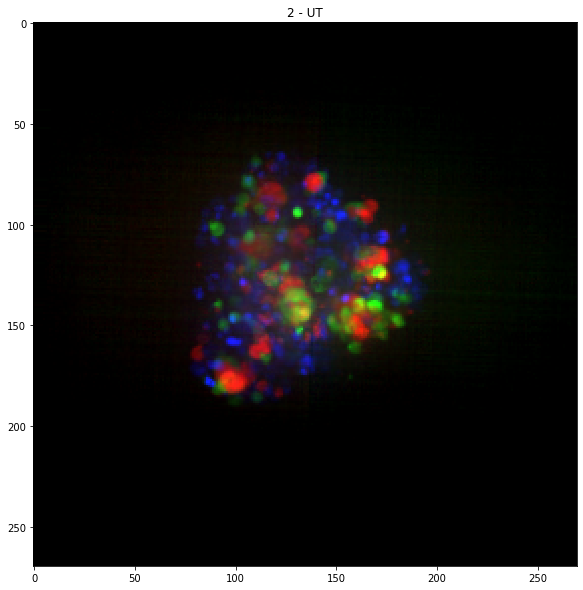

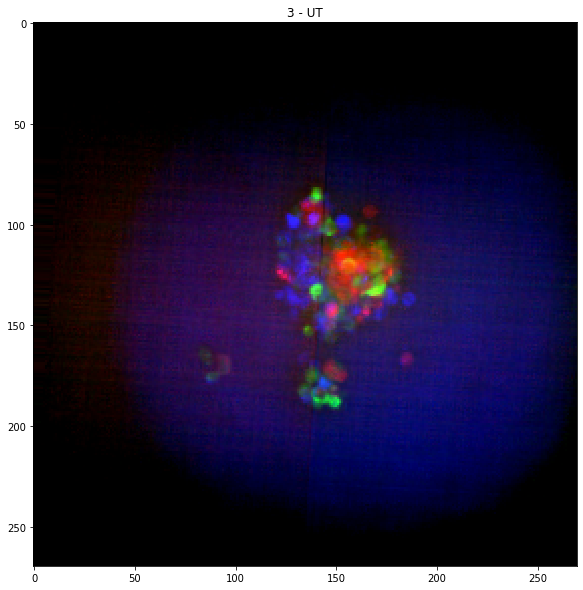

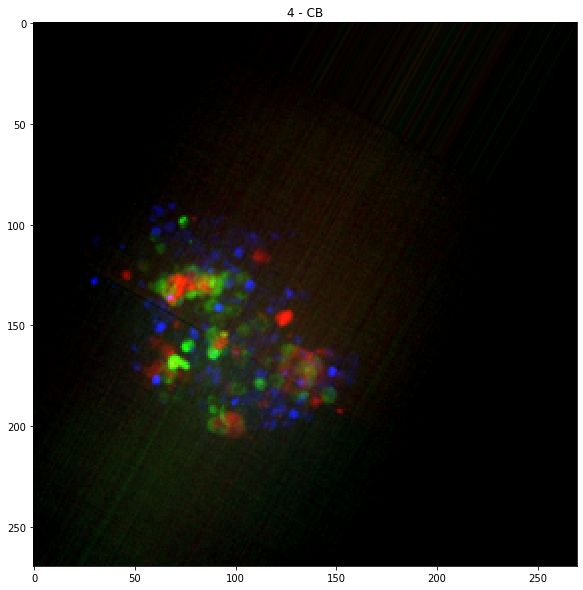

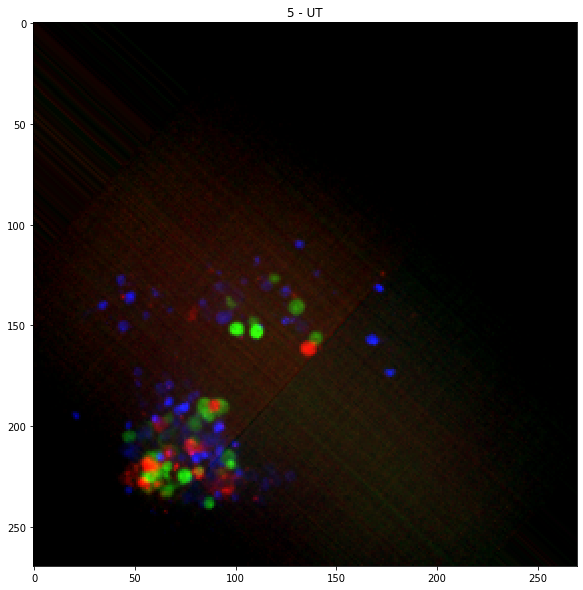

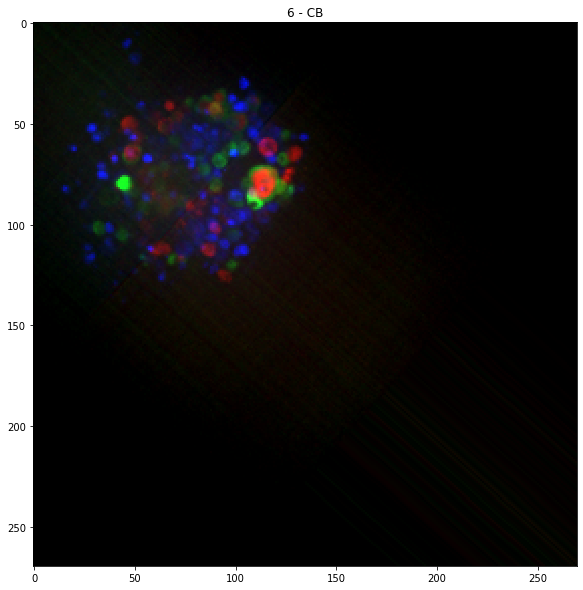

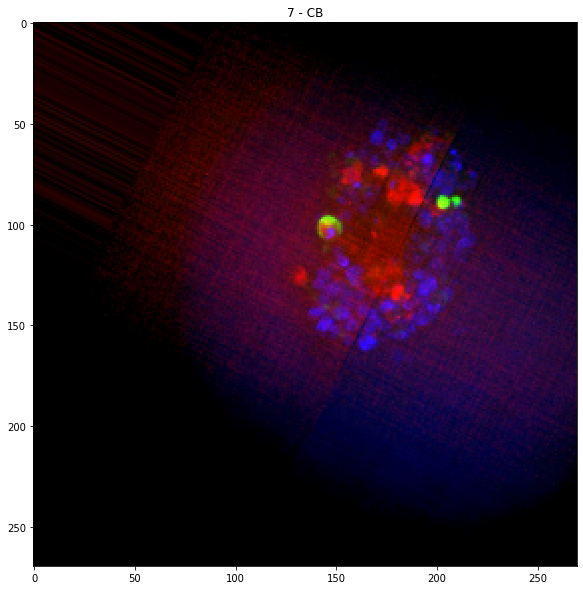

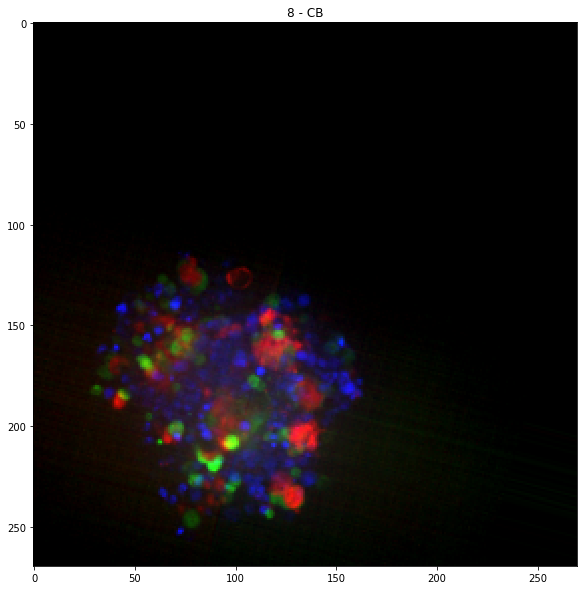

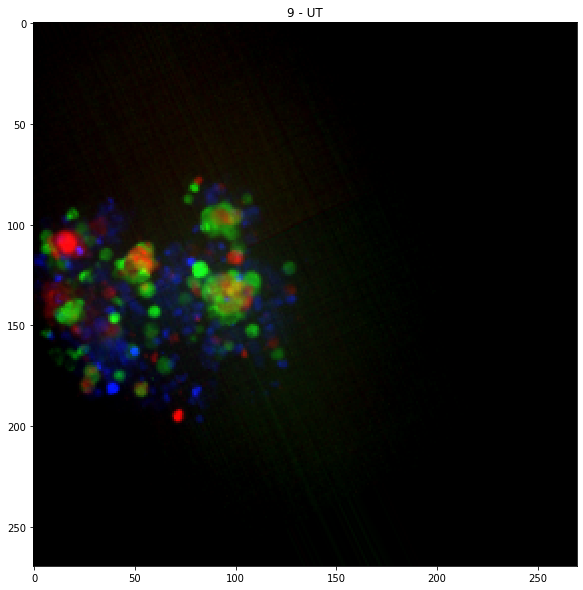

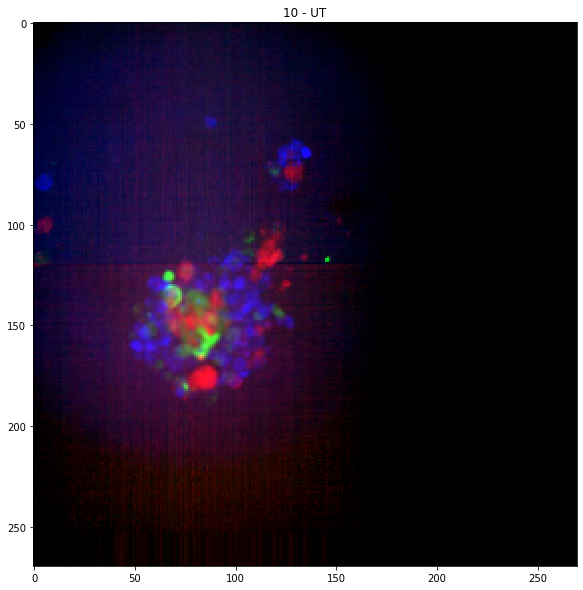

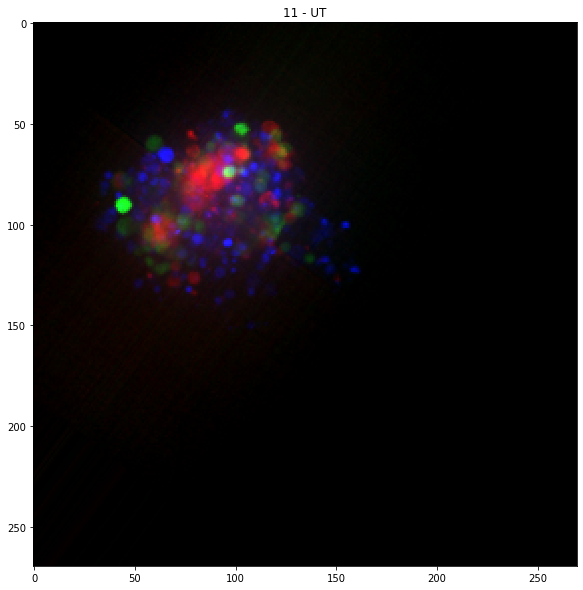

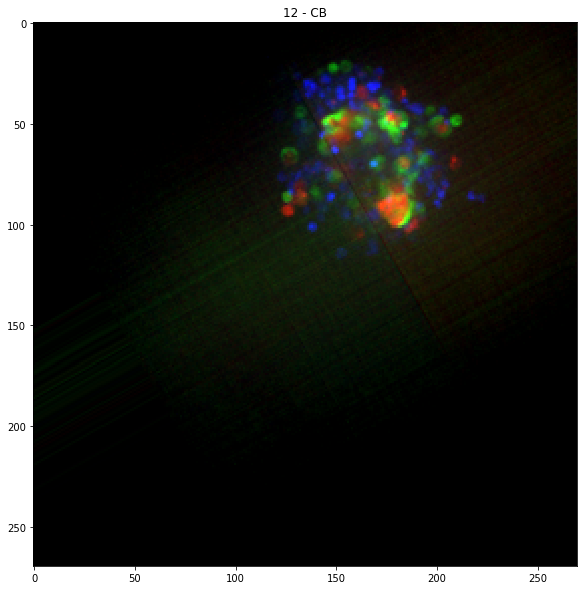

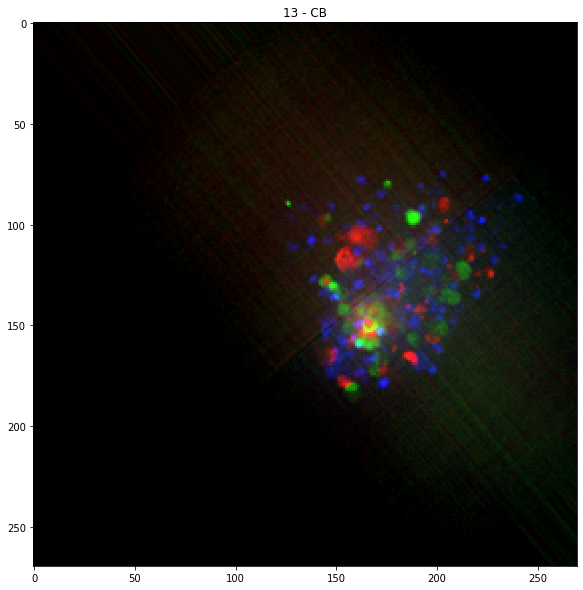

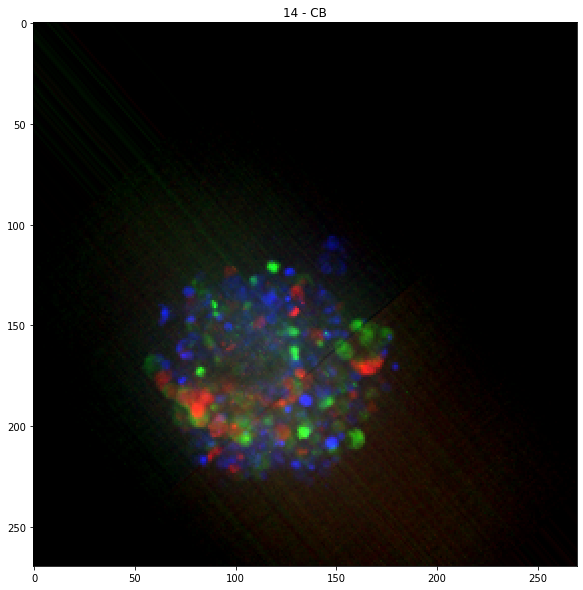

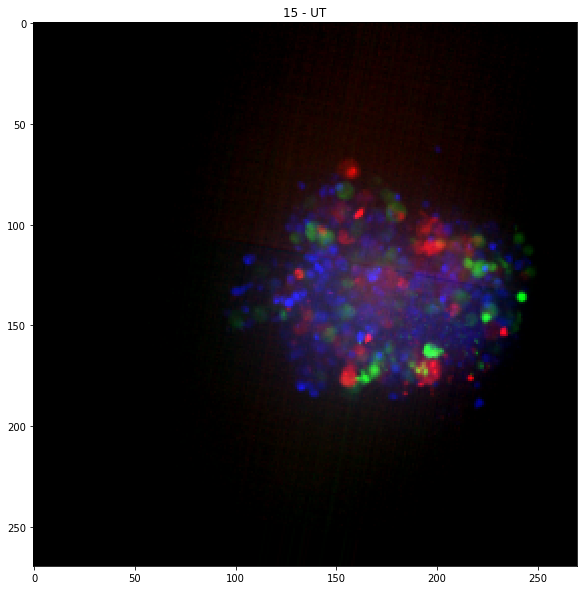

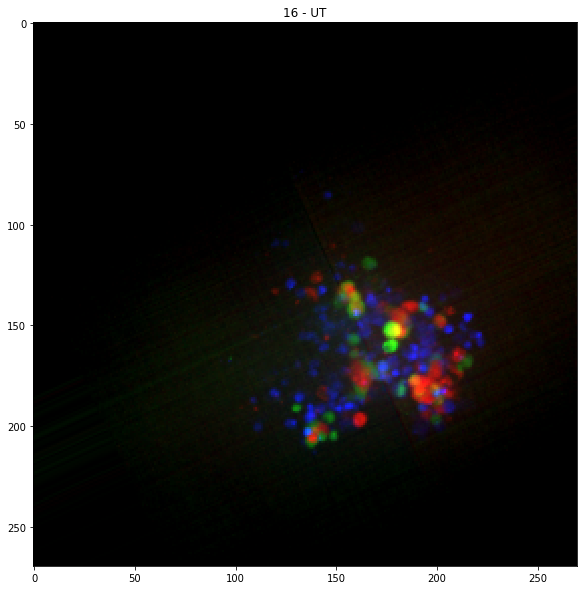

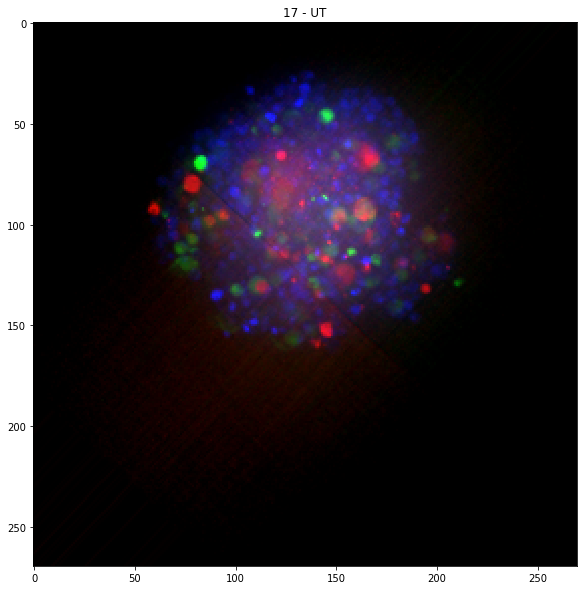

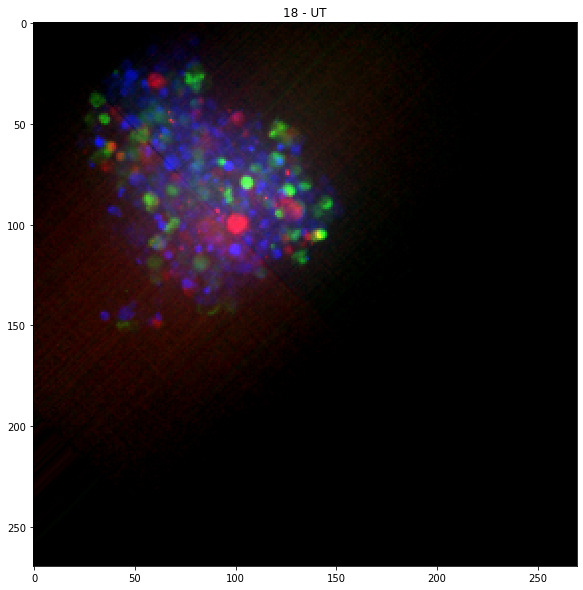

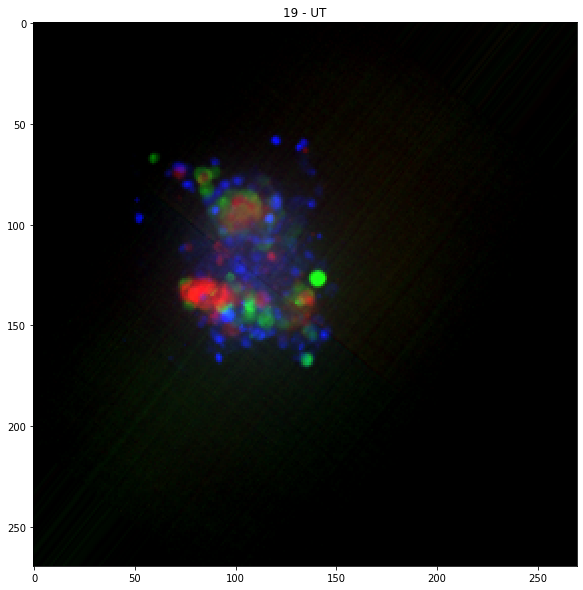

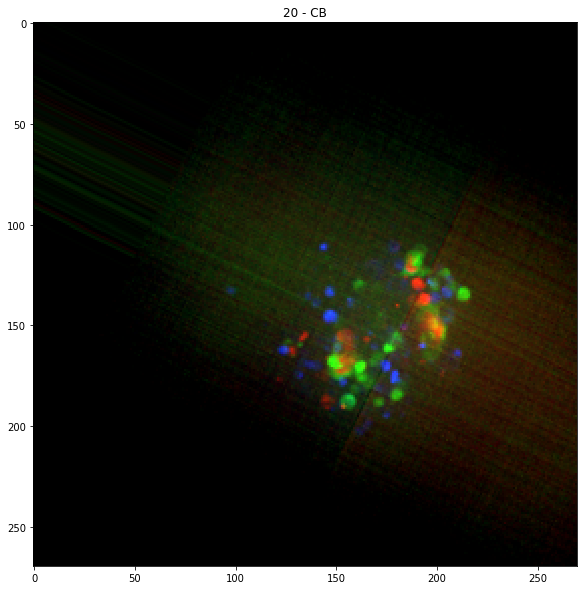

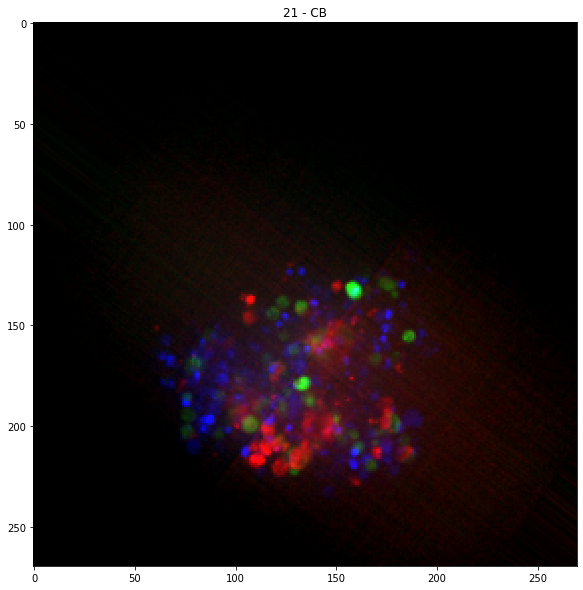

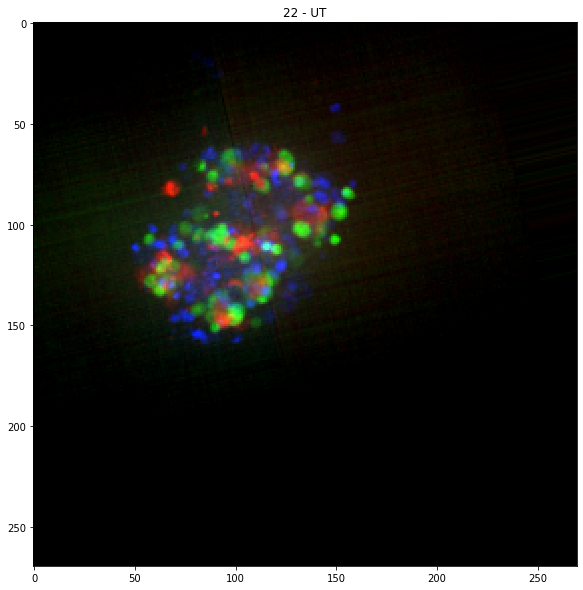

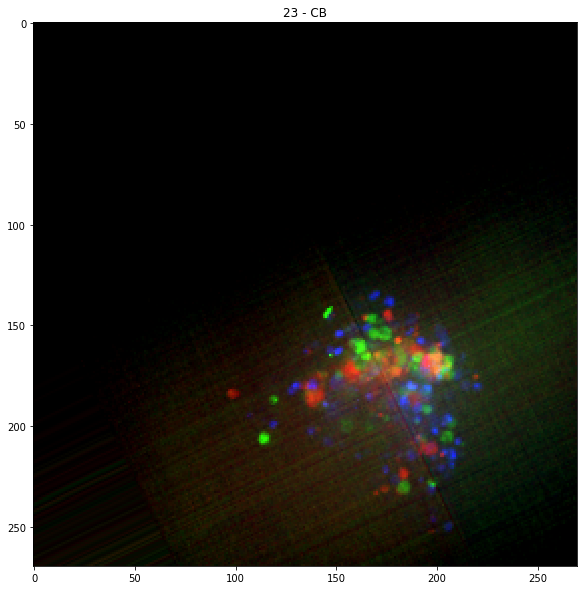

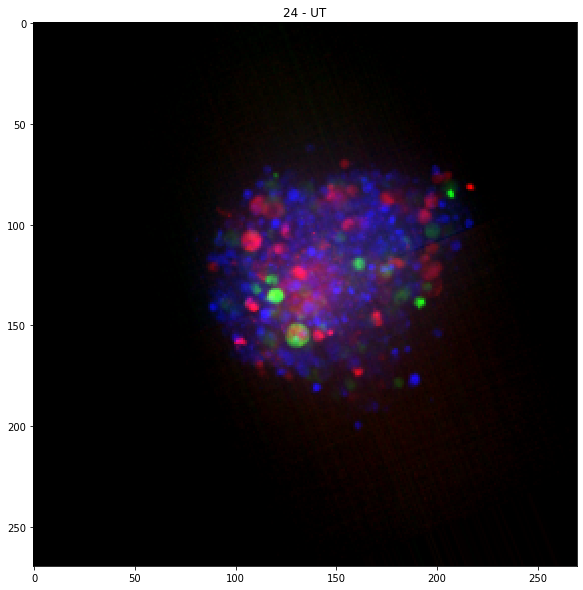

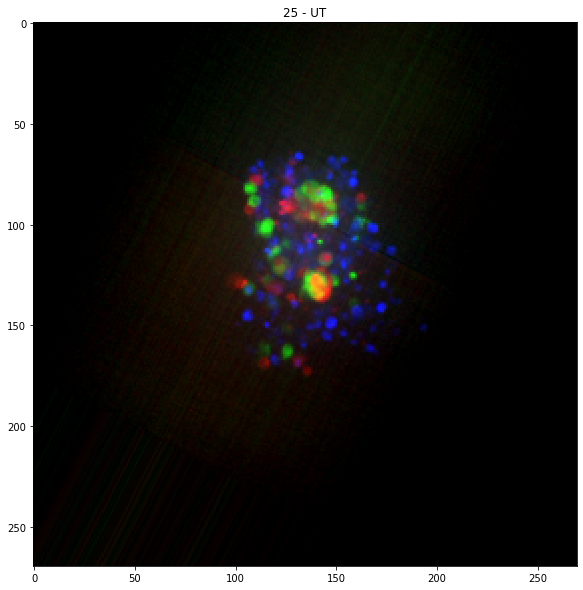

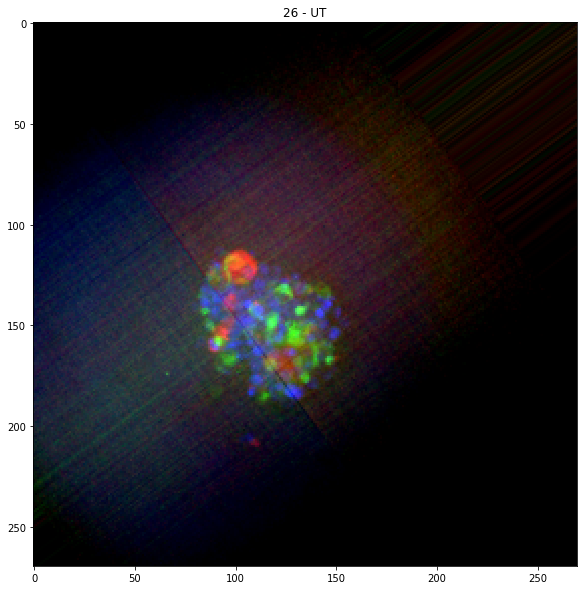

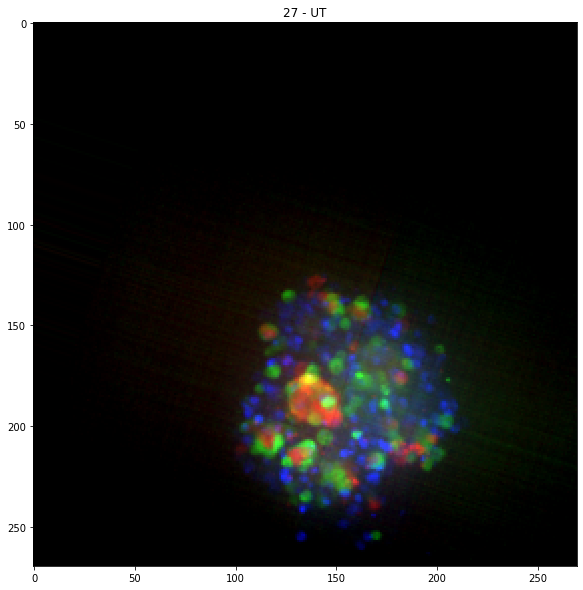

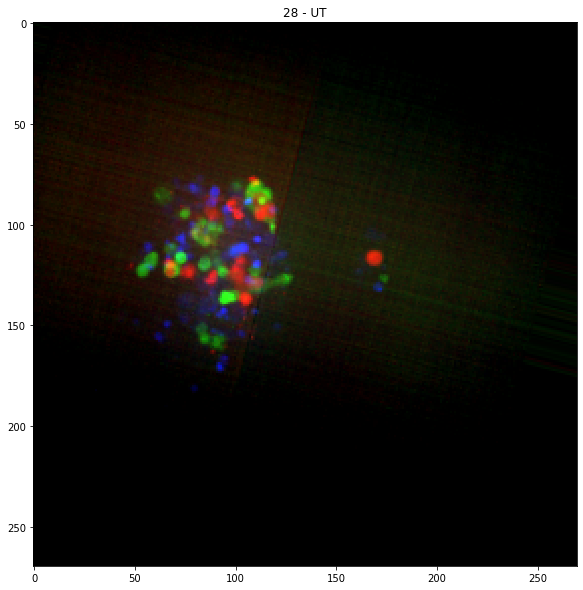

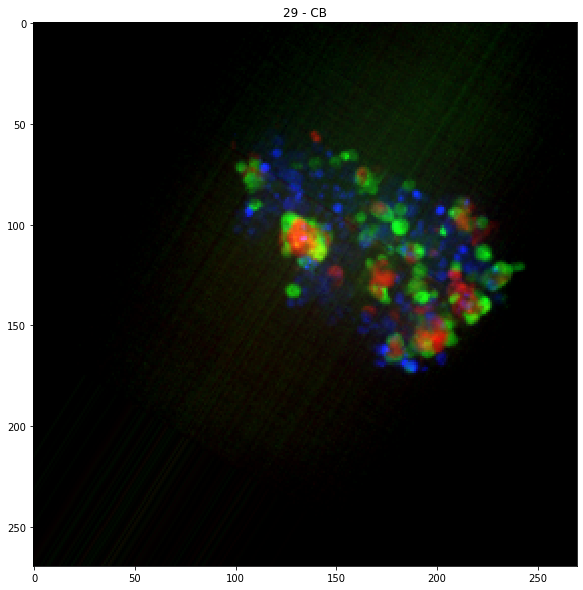

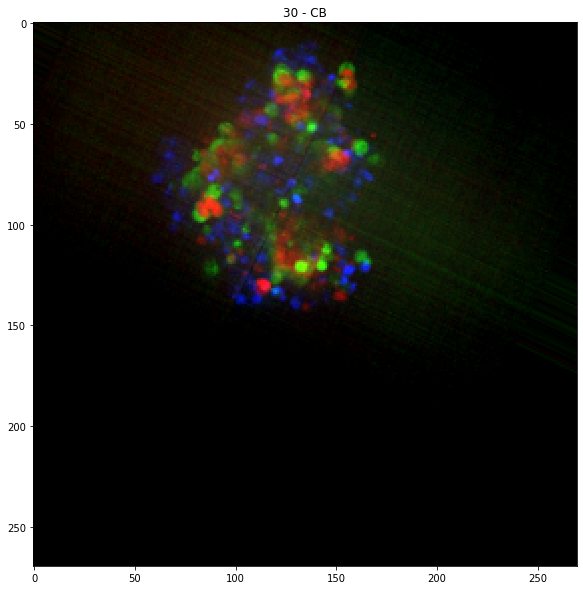

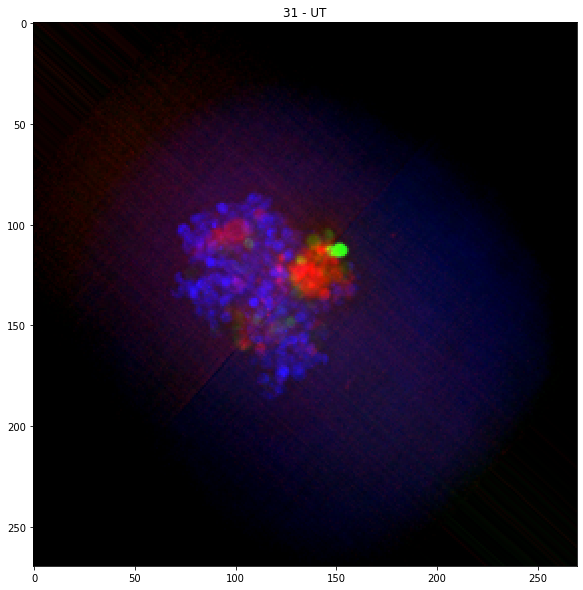

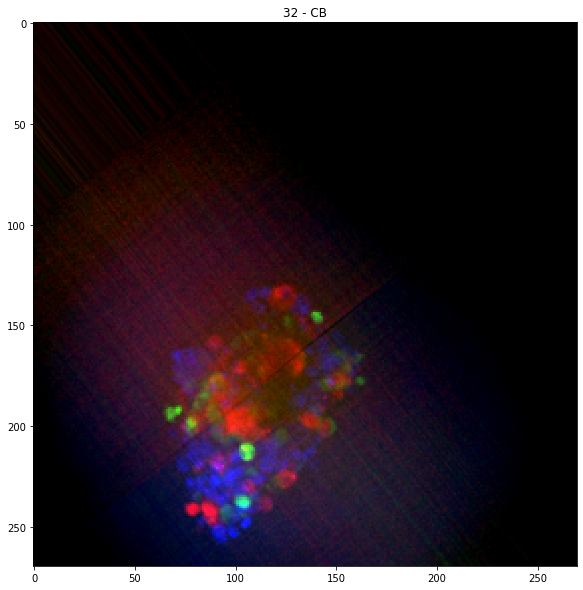

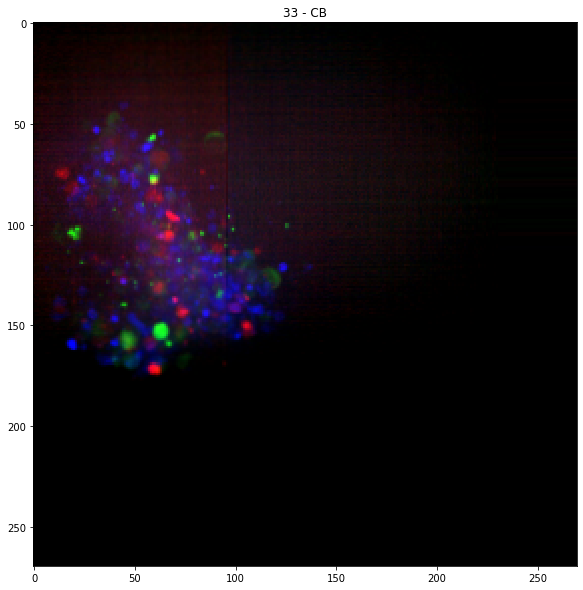

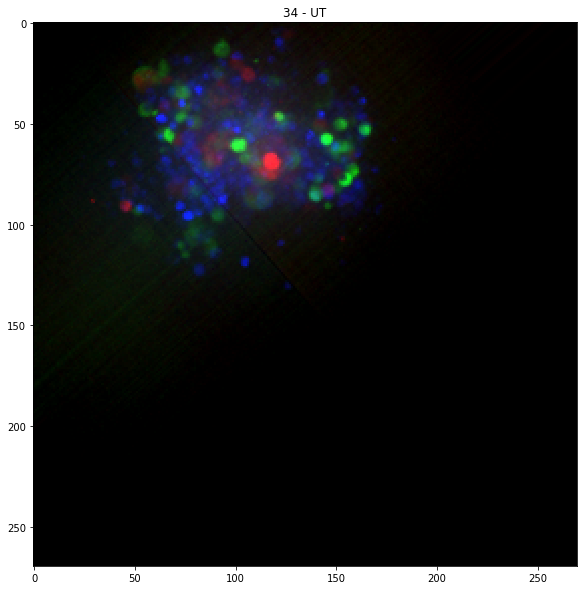

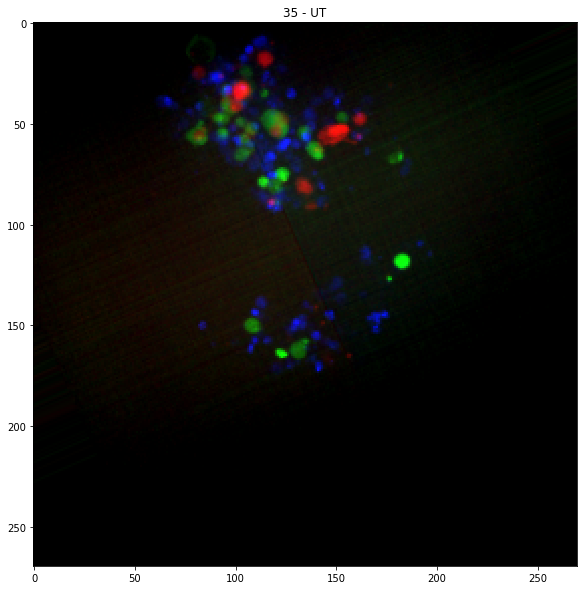

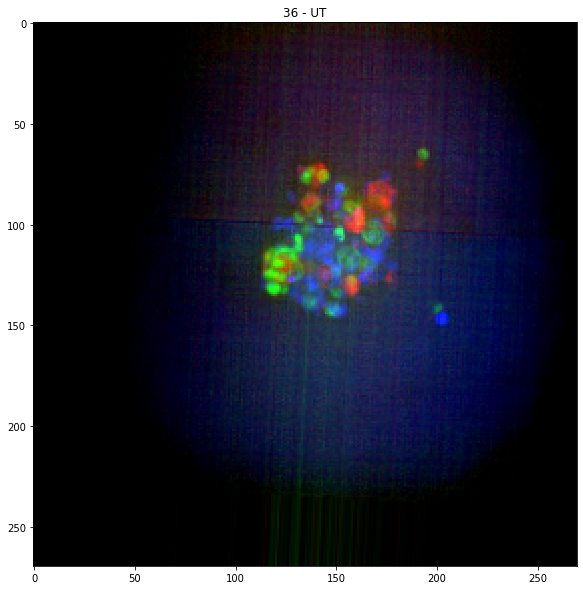

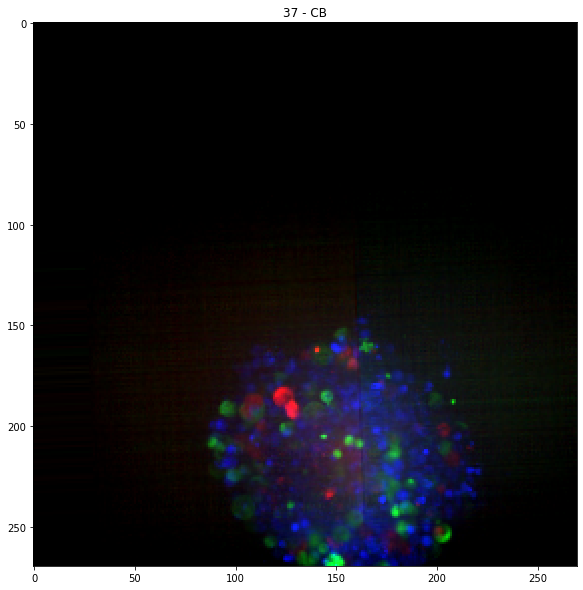

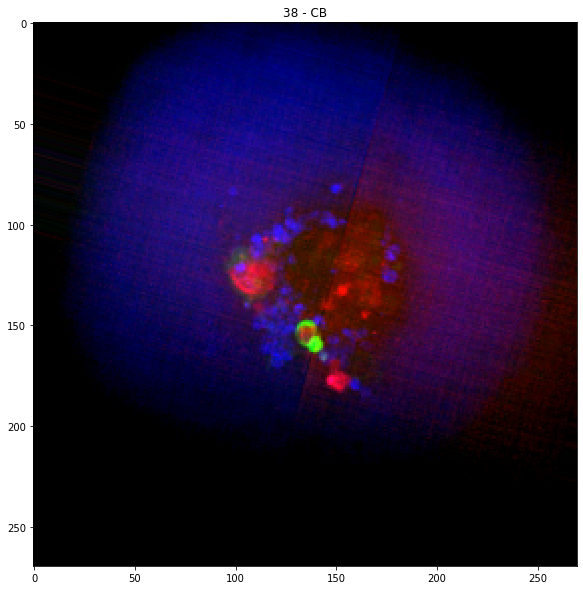

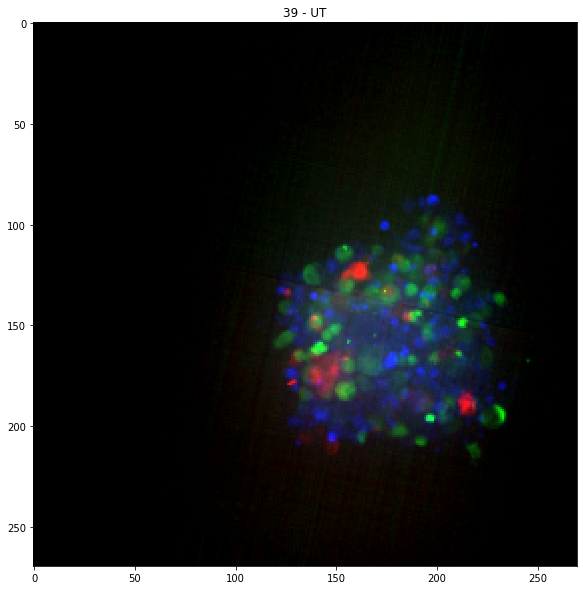

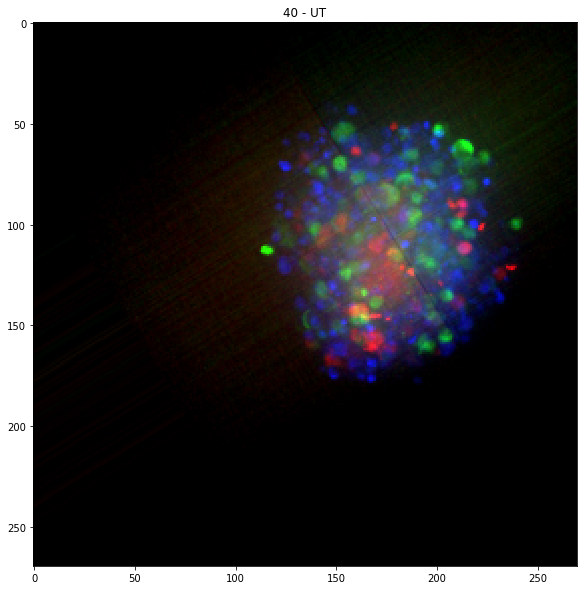

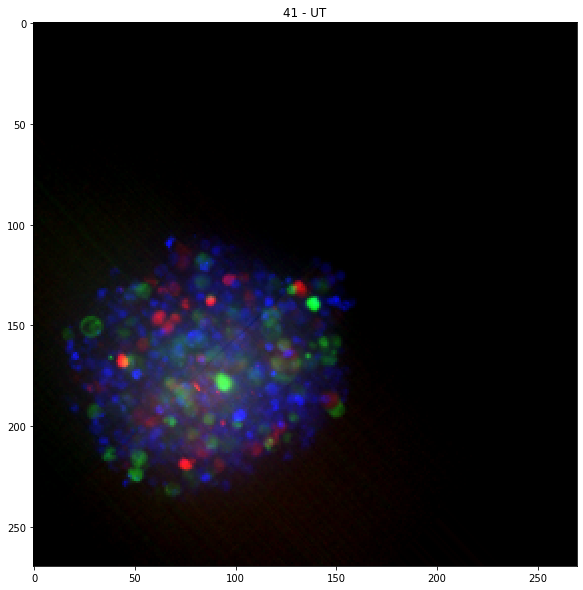

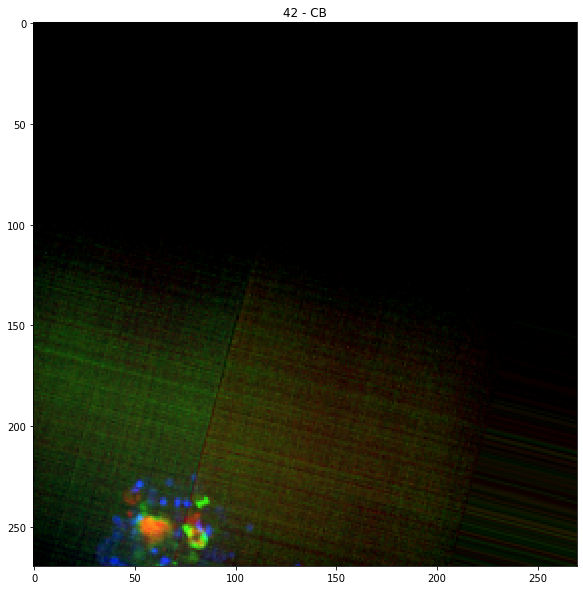

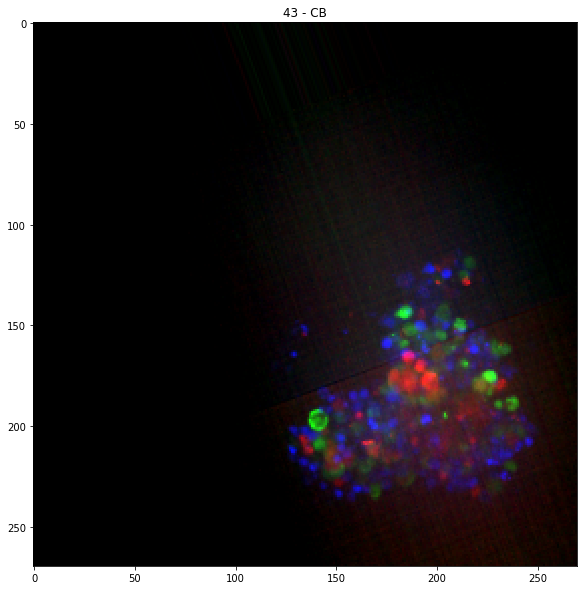

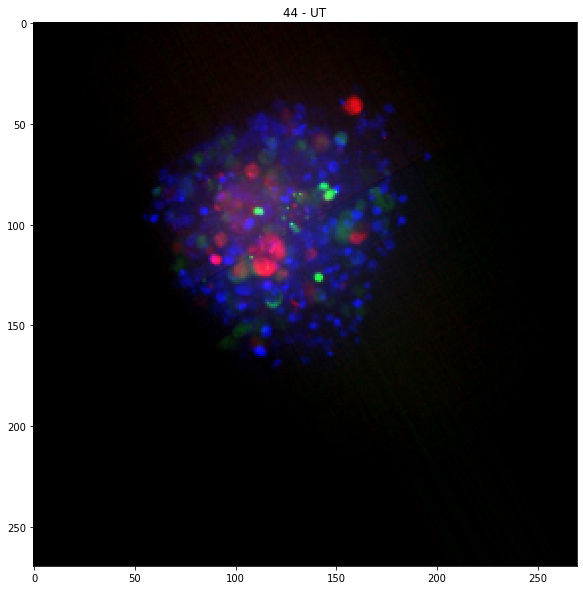

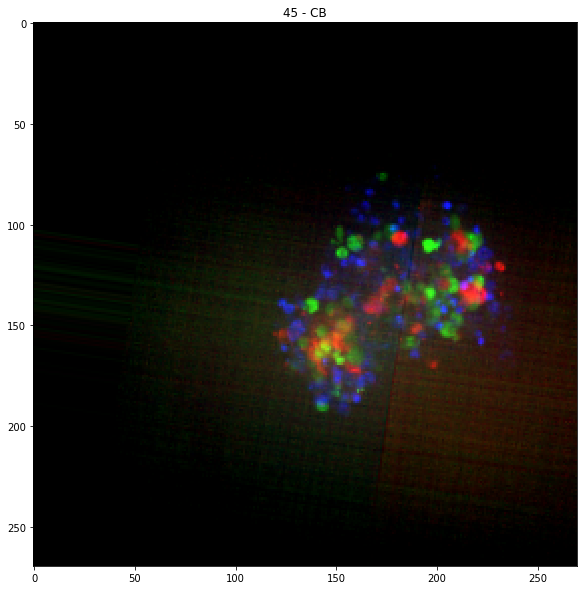

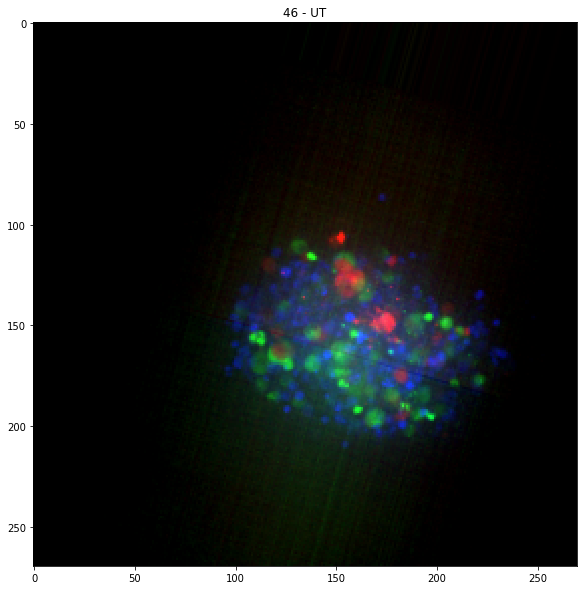

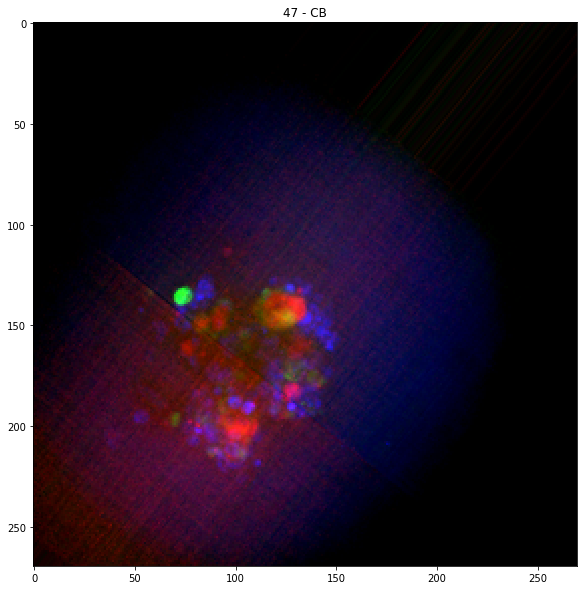

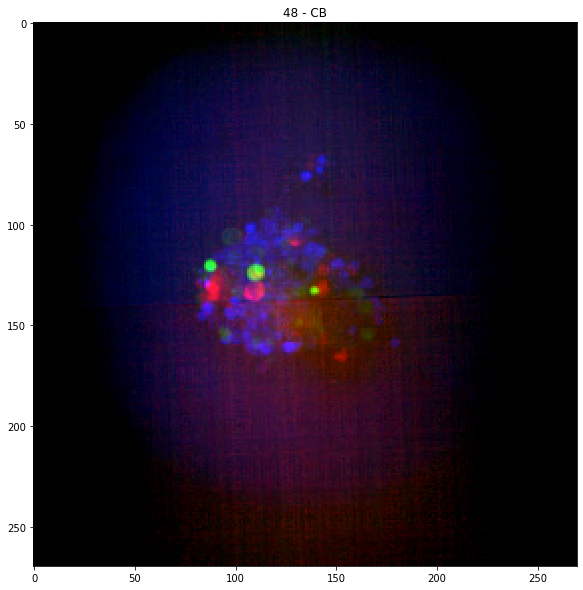

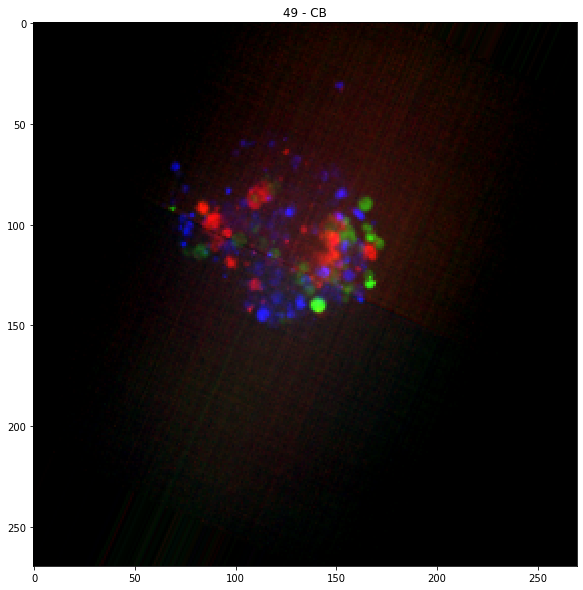

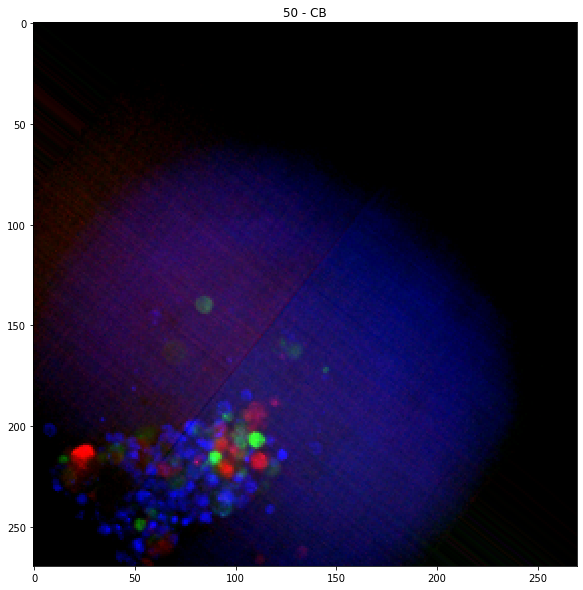

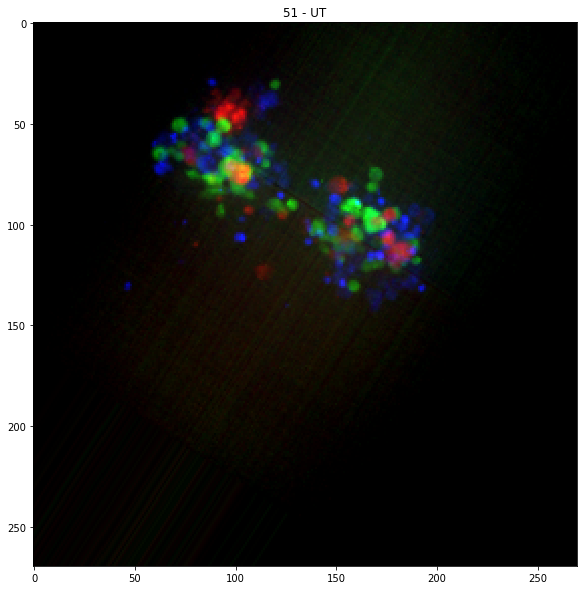

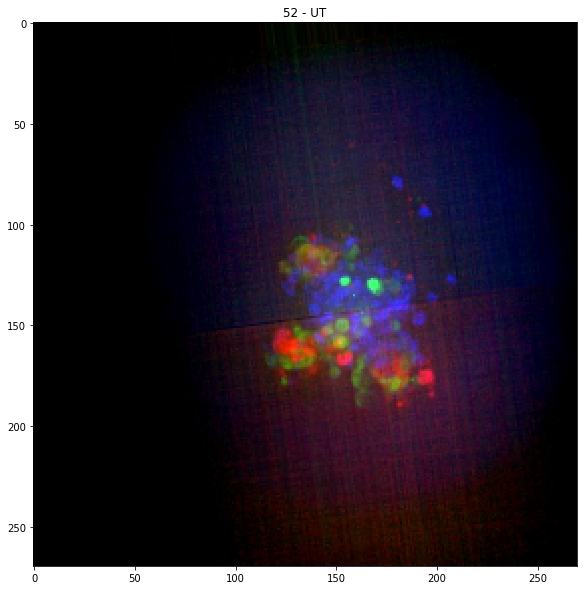

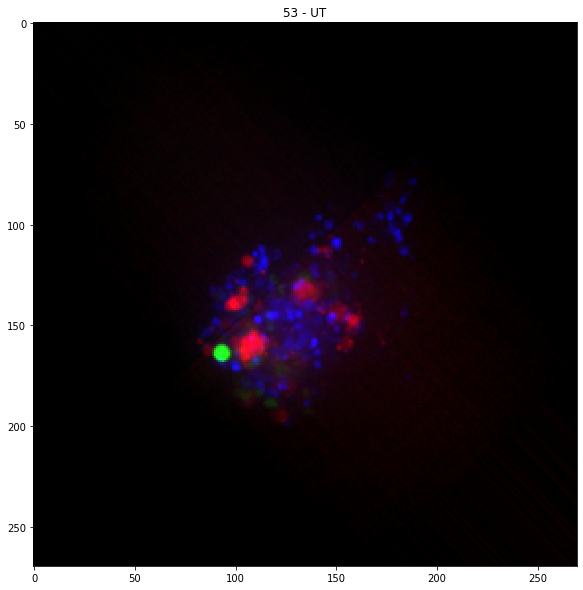

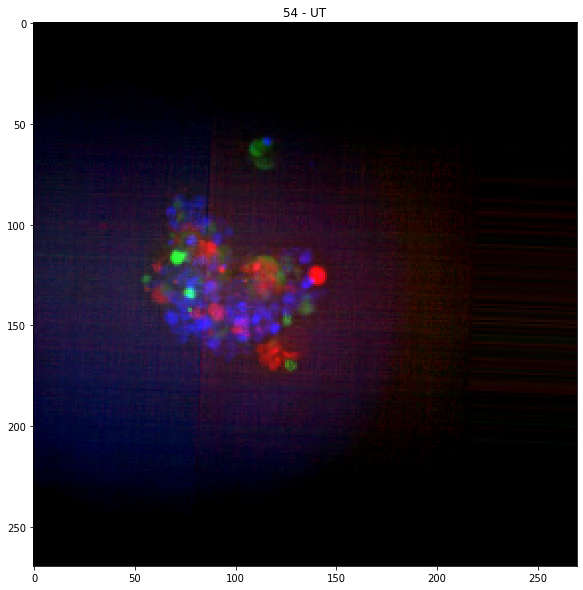

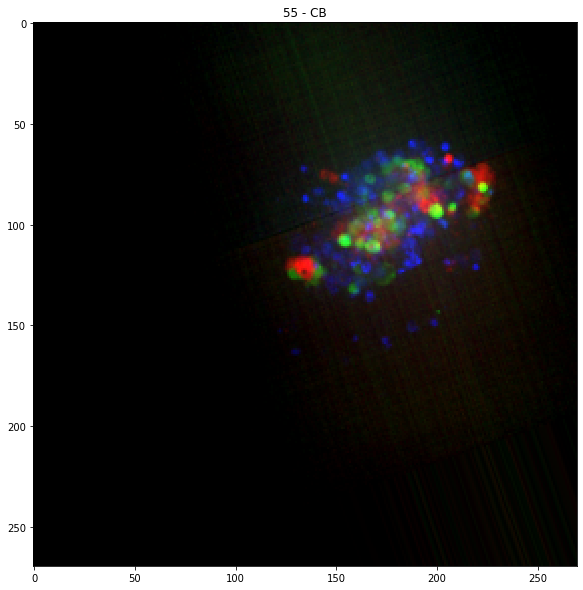

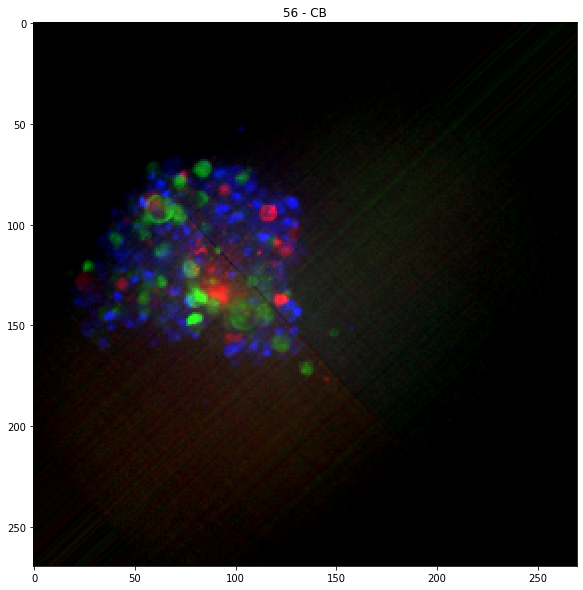

In [35]:
from matplotlib import pyplot as plt
count = 0 
for X_batch, y_batch in train_generator:
    
    if count > 50 : # stop after 50 images
        break
        
    # create a grid of 3x3 images
    for i in range(0, len(X_batch)):
        count+=1
        label = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(y_batch[i])]

        fig = plt.figure(figsize = (10,10))
        sp = fig.add_subplot(111)
        sp.set_title(str(count) + " - " + label)
        if CHANNELS == 1:
            sp.imshow(X_batch[i].reshape(IMAGE_SIZE,IMAGE_SIZE), interpolation='none',  cmap='gray')
        else:
            sp.imshow(X_batch[i].reshape(IMG_SHAPE), interpolation='none')

        # show the plot
        plt.show()



In [130]:
#create network
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Dropout, Flatten, add
from tensorflow.keras.optimizers import RMSprop

stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(5,5),strides = stride,padding = "same")(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(5,5),strides = stride,padding = "same")(temp)

    x = add([temp,Conv2D(filters,(5,5),strides = stride,padding = "same")(x)])
    if pooling:
        x = MaxPooling2D((4,4))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x


inp = Input(shape = IMG_SHAPE)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,8,dropout = 0.4,pooling = True)
x = res_layer(x,16,dropout = 0.4,pooling = True)
x = res_layer(x,32,dropout = 0.4,pooling = True)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(2048,activation = "relu", bias_initializer='zeros')(x)
x = Dropout(0.4)(x)
x = Dense(1,activation = "sigmoid")(x)

model = Model(inp,x,name = "Resnet")


learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
         
model.summary()


Model: "Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 270, 270, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 270, 270, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 270, 270, 16) 64          conv2d_80[0][0]                  
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 270, 270, 16) 0           batch_normalization_53[0][0]     
_____________________________________________________________________________________________

In [131]:
#Train network
from PIL import Image

num_epochs = 8000
steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = validation_generator.n//validation_generator.batch_size

history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=val_steps)

Train for 6 steps, validate for 2 steps
Epoch 1/8000
6/6 [==============================] - 5s 767ms/step - loss: 0.8018 - accuracy: 0.4568 - val_loss: 0.6930 - val_accuracy: 0.5312
Epoch 2/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.7263 - accuracy: 0.5062 - val_loss: 0.6932 - val_accuracy: 0.5312
Epoch 3/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.7271 - accuracy: 0.5625 - val_loss: 0.6932 - val_accuracy: 0.4375
Epoch 4/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.7051 - accuracy: 0.4691 - val_loss: 0.6932 - val_accuracy: 0.4688
Epoch 5/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.8502 - accuracy: 0.5309 - val_loss: 0.6931 - val_accuracy: 0.5312
Epoch 6/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.8137 - accuracy: 0.4815 - val_loss: 0.6930 - val_accuracy: 0.5312
Epoch 7/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.7746 - accuracy: 0.5679 - val_lo

6/6 [==============================] - 2s 375ms/step - loss: 0.7500 - accuracy: 0.4198 - val_loss: 0.6914 - val_accuracy: 0.5312
Epoch 59/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.7270 - accuracy: 0.5432 - val_loss: 0.6932 - val_accuracy: 0.5312
Epoch 60/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.9989 - accuracy: 0.5185 - val_loss: 0.6917 - val_accuracy: 0.5312
Epoch 61/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.6838 - accuracy: 0.5432 - val_loss: 0.6916 - val_accuracy: 0.5312
Epoch 62/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.7392 - accuracy: 0.5679 - val_loss: 0.6911 - val_accuracy: 0.5312
Epoch 63/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.6960 - accuracy: 0.5926 - val_loss: 0.6921 - val_accuracy: 0.5312
Epoch 64/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.6750 - accuracy: 0.5432 - val_loss: 0.6923 - val_accuracy: 0.5312
Epoch 65/8000

Epoch 172/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.8108 - accuracy: 0.4198 - val_loss: 0.6862 - val_accuracy: 0.5312
Epoch 173/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.8533 - accuracy: 0.4568 - val_loss: 0.6888 - val_accuracy: 0.5312
Epoch 174/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.7888 - accuracy: 0.4815 - val_loss: 0.6932 - val_accuracy: 0.5312
Epoch 175/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.6674 - accuracy: 0.4938 - val_loss: 0.6950 - val_accuracy: 0.5312
Epoch 176/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.7681 - accuracy: 0.5208 - val_loss: 0.6918 - val_accuracy: 0.5312
Epoch 177/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.6492 - accuracy: 0.6049 - val_loss: 0.6832 - val_accuracy: 0.5312
Epoch 178/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.7553 - accuracy: 0.4271 - val_loss: 0.6925 - val_accuracy:

Epoch 229/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.6559 - accuracy: 0.5432 - val_loss: 0.6937 - val_accuracy: 0.5312
Epoch 230/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.7303 - accuracy: 0.4568 - val_loss: 0.6936 - val_accuracy: 0.5312
Epoch 231/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.7022 - accuracy: 0.5185 - val_loss: 0.6956 - val_accuracy: 0.5312
Epoch 232/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.6835 - accuracy: 0.4938 - val_loss: 0.7036 - val_accuracy: 0.5312
Epoch 233/8000
6/6 [==============================] - 2s 391ms/step - loss: 0.7397 - accuracy: 0.4896 - val_loss: 0.6917 - val_accuracy: 0.5312
Epoch 234/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.7197 - accuracy: 0.5062 - val_loss: 0.6851 - val_accuracy: 0.5312
Epoch 235/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.6660 - accuracy: 0.5679 - val_loss: 0.6909 - val_accuracy:

Epoch 286/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.7007 - accuracy: 0.5802 - val_loss: 0.6950 - val_accuracy: 0.5312
Epoch 287/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.6591 - accuracy: 0.5185 - val_loss: 0.6932 - val_accuracy: 0.5312
Epoch 288/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.6722 - accuracy: 0.6173 - val_loss: 0.7049 - val_accuracy: 0.5312
Epoch 289/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.7022 - accuracy: 0.5185 - val_loss: 0.7090 - val_accuracy: 0.5312
Epoch 290/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.7668 - accuracy: 0.4938 - val_loss: 0.6957 - val_accuracy: 0.5312
Epoch 291/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.7193 - accuracy: 0.4938 - val_loss: 0.6935 - val_accuracy: 0.5312
Epoch 292/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.6615 - accuracy: 0.5185 - val_loss: 0.6994 - val_accuracy:

Epoch 343/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.7146 - accuracy: 0.5556 - val_loss: 0.7015 - val_accuracy: 0.5312
Epoch 344/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.6972 - accuracy: 0.4691 - val_loss: 0.7028 - val_accuracy: 0.5312
Epoch 345/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.7100 - accuracy: 0.4691 - val_loss: 0.6958 - val_accuracy: 0.5312
Epoch 346/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.6796 - accuracy: 0.6296 - val_loss: 0.6958 - val_accuracy: 0.5312
Epoch 347/8000
6/6 [==============================] - 2s 389ms/step - loss: 0.7490 - accuracy: 0.4688 - val_loss: 0.6946 - val_accuracy: 0.5312
Epoch 348/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.8025 - accuracy: 0.4444 - val_loss: 0.6947 - val_accuracy: 0.5312
Epoch 349/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.7030 - accuracy: 0.4321 - val_loss: 0.6938 - val_accuracy:

Epoch 400/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.6870 - accuracy: 0.5432 - val_loss: 0.7015 - val_accuracy: 0.5312
Epoch 401/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.6770 - accuracy: 0.5802 - val_loss: 0.6988 - val_accuracy: 0.5312
Epoch 402/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.6922 - accuracy: 0.5062 - val_loss: 0.6989 - val_accuracy: 0.5312
Epoch 403/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.6915 - accuracy: 0.5185 - val_loss: 0.7018 - val_accuracy: 0.5312
Epoch 404/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.7765 - accuracy: 0.4568 - val_loss: 0.6970 - val_accuracy: 0.5312
Epoch 405/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.7213 - accuracy: 0.4568 - val_loss: 0.6988 - val_accuracy: 0.5312
Epoch 406/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.7145 - accuracy: 0.5185 - val_loss: 0.7002 - val_accuracy:

Epoch 457/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.7970 - accuracy: 0.5062 - val_loss: 0.7122 - val_accuracy: 0.5312
Epoch 458/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.6734 - accuracy: 0.5556 - val_loss: 0.7119 - val_accuracy: 0.5312
Epoch 459/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.7329 - accuracy: 0.4815 - val_loss: 0.7210 - val_accuracy: 0.5312
Epoch 460/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.7098 - accuracy: 0.4691 - val_loss: 0.7117 - val_accuracy: 0.5312
Epoch 461/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.7055 - accuracy: 0.5062 - val_loss: 0.7122 - val_accuracy: 0.5312
Epoch 462/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.7424 - accuracy: 0.5309 - val_loss: 0.7177 - val_accuracy: 0.5312
Epoch 463/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.6865 - accuracy: 0.4938 - val_loss: 0.7166 - val_accuracy:

Epoch 514/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.6472 - accuracy: 0.6049 - val_loss: 0.6968 - val_accuracy: 0.5312
Epoch 515/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.6603 - accuracy: 0.5556 - val_loss: 0.7096 - val_accuracy: 0.5312
Epoch 516/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.6919 - accuracy: 0.5062 - val_loss: 0.7062 - val_accuracy: 0.5312
Epoch 517/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.7618 - accuracy: 0.4479 - val_loss: 0.7074 - val_accuracy: 0.5312
Epoch 518/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.8210 - accuracy: 0.4444 - val_loss: 0.7015 - val_accuracy: 0.5312
Epoch 519/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.6453 - accuracy: 0.5556 - val_loss: 0.7068 - val_accuracy: 0.5312
Epoch 520/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.7647 - accuracy: 0.5926 - val_loss: 0.7099 - val_accuracy:

Epoch 571/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.6195 - accuracy: 0.5556 - val_loss: 0.6944 - val_accuracy: 0.5312
Epoch 572/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.7920 - accuracy: 0.4938 - val_loss: 0.6968 - val_accuracy: 0.5312
Epoch 573/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.7180 - accuracy: 0.4321 - val_loss: 0.6984 - val_accuracy: 0.5312
Epoch 574/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.6808 - accuracy: 0.5185 - val_loss: 0.6960 - val_accuracy: 0.5312
Epoch 575/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.6700 - accuracy: 0.4691 - val_loss: 0.6971 - val_accuracy: 0.5312
Epoch 576/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.6667 - accuracy: 0.5062 - val_loss: 0.6938 - val_accuracy: 0.5312
Epoch 577/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.6652 - accuracy: 0.5802 - val_loss: 0.7010 - val_accuracy:

Epoch 628/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.6565 - accuracy: 0.5062 - val_loss: 0.6969 - val_accuracy: 0.5312
Epoch 629/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.6764 - accuracy: 0.5062 - val_loss: 0.6907 - val_accuracy: 0.5312
Epoch 630/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.6292 - accuracy: 0.5802 - val_loss: 0.6923 - val_accuracy: 0.5312
Epoch 631/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.6370 - accuracy: 0.5802 - val_loss: 0.6840 - val_accuracy: 0.5312
Epoch 632/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.7454 - accuracy: 0.4938 - val_loss: 0.6927 - val_accuracy: 0.5312
Epoch 633/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.6982 - accuracy: 0.4938 - val_loss: 0.6908 - val_accuracy: 0.5312
Epoch 634/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.7106 - accuracy: 0.5185 - val_loss: 0.6898 - val_accuracy:

Epoch 685/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.6646 - accuracy: 0.6173 - val_loss: 0.6806 - val_accuracy: 0.5312
Epoch 686/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.7548 - accuracy: 0.5309 - val_loss: 0.6797 - val_accuracy: 0.5625
Epoch 687/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.6422 - accuracy: 0.6173 - val_loss: 0.6850 - val_accuracy: 0.5625
Epoch 688/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.6918 - accuracy: 0.5802 - val_loss: 0.6816 - val_accuracy: 0.5312
Epoch 689/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.6643 - accuracy: 0.5185 - val_loss: 0.6678 - val_accuracy: 0.5625
Epoch 690/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.6767 - accuracy: 0.5802 - val_loss: 0.6497 - val_accuracy: 0.5938
Epoch 691/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.6828 - accuracy: 0.5185 - val_loss: 0.6559 - val_accuracy:

Epoch 742/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.6608 - accuracy: 0.6042 - val_loss: 0.6509 - val_accuracy: 0.5625
Epoch 743/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.5896 - accuracy: 0.7083 - val_loss: 0.6459 - val_accuracy: 0.5938
Epoch 744/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.6542 - accuracy: 0.5926 - val_loss: 0.6141 - val_accuracy: 0.6562
Epoch 745/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.6073 - accuracy: 0.6667 - val_loss: 0.5999 - val_accuracy: 0.6875
Epoch 746/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.5784 - accuracy: 0.6543 - val_loss: 0.6147 - val_accuracy: 0.5938
Epoch 747/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.6205 - accuracy: 0.7037 - val_loss: 0.6507 - val_accuracy: 0.5625
Epoch 748/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.5519 - accuracy: 0.7160 - val_loss: 0.6824 - val_accuracy:

Epoch 799/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.5483 - accuracy: 0.6914 - val_loss: 0.4884 - val_accuracy: 0.7812
Epoch 800/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.5512 - accuracy: 0.7778 - val_loss: 0.5172 - val_accuracy: 0.7188
Epoch 801/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.6451 - accuracy: 0.6173 - val_loss: 0.5859 - val_accuracy: 0.6250
Epoch 802/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.5221 - accuracy: 0.7160 - val_loss: 0.5461 - val_accuracy: 0.6562
Epoch 803/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.5252 - accuracy: 0.7284 - val_loss: 0.4909 - val_accuracy: 0.7500
Epoch 804/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.5317 - accuracy: 0.7037 - val_loss: 0.4816 - val_accuracy: 0.8125
Epoch 805/8000
6/6 [==============================] - 2s 389ms/step - loss: 0.5739 - accuracy: 0.6875 - val_loss: 0.5105 - val_accuracy:

Epoch 856/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.3789 - accuracy: 0.8272 - val_loss: 0.5073 - val_accuracy: 0.7188
Epoch 857/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.4298 - accuracy: 0.7778 - val_loss: 0.8453 - val_accuracy: 0.5625
Epoch 858/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.3992 - accuracy: 0.8272 - val_loss: 0.4724 - val_accuracy: 0.8125
Epoch 859/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.3476 - accuracy: 0.8272 - val_loss: 0.3977 - val_accuracy: 0.8125
Epoch 860/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.4033 - accuracy: 0.8025 - val_loss: 0.4335 - val_accuracy: 0.8125
Epoch 861/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.4987 - accuracy: 0.7160 - val_loss: 0.7635 - val_accuracy: 0.7188
Epoch 862/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.3722 - accuracy: 0.8272 - val_loss: 0.4863 - val_accuracy:

Epoch 913/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.2472 - accuracy: 0.9136 - val_loss: 0.6225 - val_accuracy: 0.6250
Epoch 914/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.2485 - accuracy: 0.8889 - val_loss: 0.7264 - val_accuracy: 0.5625
Epoch 915/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.2384 - accuracy: 0.9383 - val_loss: 0.6454 - val_accuracy: 0.6250
Epoch 916/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.2917 - accuracy: 0.8272 - val_loss: 0.7936 - val_accuracy: 0.7812
Epoch 917/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.2812 - accuracy: 0.8642 - val_loss: 0.6068 - val_accuracy: 0.8750
Epoch 918/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.3436 - accuracy: 0.8333 - val_loss: 0.4845 - val_accuracy: 0.8125
Epoch 919/8000
6/6 [==============================] - 2s 391ms/step - loss: 0.4655 - accuracy: 0.8333 - val_loss: 0.8887 - val_accuracy:

Epoch 970/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.3272 - accuracy: 0.8765 - val_loss: 1.3354 - val_accuracy: 0.8438
Epoch 971/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.1918 - accuracy: 0.9259 - val_loss: 1.4101 - val_accuracy: 0.8750
Epoch 972/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.2316 - accuracy: 0.8889 - val_loss: 1.0358 - val_accuracy: 0.7500
Epoch 973/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.2221 - accuracy: 0.8889 - val_loss: 1.3017 - val_accuracy: 0.5938
Epoch 974/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.3070 - accuracy: 0.8395 - val_loss: 1.4580 - val_accuracy: 0.5000
Epoch 975/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.2406 - accuracy: 0.8642 - val_loss: 1.1552 - val_accuracy: 0.7812
Epoch 976/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.1811 - accuracy: 0.9259 - val_loss: 1.0719 - val_accuracy:

Epoch 1027/8000
6/6 [==============================] - 2s 390ms/step - loss: 0.2984 - accuracy: 0.8750 - val_loss: 1.7070 - val_accuracy: 0.8750
Epoch 1028/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.2240 - accuracy: 0.8889 - val_loss: 1.3601 - val_accuracy: 0.8438
Epoch 1029/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.2553 - accuracy: 0.8642 - val_loss: 1.6334 - val_accuracy: 0.8125
Epoch 1030/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.1978 - accuracy: 0.8889 - val_loss: 1.5249 - val_accuracy: 0.8438
Epoch 1031/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.2397 - accuracy: 0.9062 - val_loss: 1.5630 - val_accuracy: 0.8750
Epoch 1032/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.2912 - accuracy: 0.8642 - val_loss: 1.4590 - val_accuracy: 0.8750
Epoch 1033/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.1697 - accuracy: 0.9383 - val_loss: 1.5343 - val_ac

6/6 [==============================] - 2s 376ms/step - loss: 0.1948 - accuracy: 0.9259 - val_loss: 2.0447 - val_accuracy: 0.5938
Epoch 1140/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.1609 - accuracy: 0.9136 - val_loss: 2.4261 - val_accuracy: 0.8125
Epoch 1141/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.1978 - accuracy: 0.9136 - val_loss: 2.1074 - val_accuracy: 0.7812
Epoch 1142/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.1864 - accuracy: 0.9259 - val_loss: 2.1560 - val_accuracy: 0.7500
Epoch 1143/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.2264 - accuracy: 0.9136 - val_loss: 1.9804 - val_accuracy: 0.7812
Epoch 1144/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.1931 - accuracy: 0.8889 - val_loss: 2.0371 - val_accuracy: 0.8125
Epoch 1145/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.1787 - accuracy: 0.9136 - val_loss: 2.1795 - val_accuracy: 0.7812
E

6/6 [==============================] - 2s 390ms/step - loss: 0.1366 - accuracy: 0.9479 - val_loss: 3.1278 - val_accuracy: 0.6562
Epoch 1252/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.1213 - accuracy: 0.9383 - val_loss: 2.9709 - val_accuracy: 0.6562
Epoch 1253/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.1185 - accuracy: 0.9506 - val_loss: 3.4750 - val_accuracy: 0.6562
Epoch 1254/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.1835 - accuracy: 0.9136 - val_loss: 3.5406 - val_accuracy: 0.5938
Epoch 1255/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.2140 - accuracy: 0.9271 - val_loss: 2.7726 - val_accuracy: 0.5938
Epoch 1256/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.1476 - accuracy: 0.9630 - val_loss: 2.5190 - val_accuracy: 0.8125
Epoch 1257/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.2576 - accuracy: 0.8889 - val_loss: 2.5445 - val_accuracy: 0.8125
E

6/6 [==============================] - 2s 379ms/step - loss: 0.0725 - accuracy: 0.9753 - val_loss: 3.8277 - val_accuracy: 0.8750
Epoch 1364/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.1052 - accuracy: 0.9383 - val_loss: 3.0525 - val_accuracy: 0.8125
Epoch 1365/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.1278 - accuracy: 0.9506 - val_loss: 3.6639 - val_accuracy: 0.8750
Epoch 1366/8000
6/6 [==============================] - 2s 391ms/step - loss: 0.1023 - accuracy: 0.9688 - val_loss: 3.5437 - val_accuracy: 0.8750
Epoch 1367/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.1142 - accuracy: 0.9506 - val_loss: 2.8076 - val_accuracy: 0.8125
Epoch 1368/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.1097 - accuracy: 0.9630 - val_loss: 3.7484 - val_accuracy: 0.8438
Epoch 1369/8000
6/6 [==============================] - 2s 389ms/step - loss: 0.1382 - accuracy: 0.9271 - val_loss: 3.7669 - val_accuracy: 0.8750
E

6/6 [==============================] - 2s 378ms/step - loss: 0.0792 - accuracy: 0.9630 - val_loss: 4.9566 - val_accuracy: 0.8750
Epoch 1476/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0714 - accuracy: 0.9753 - val_loss: 4.2528 - val_accuracy: 0.8438
Epoch 1477/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.1403 - accuracy: 0.9383 - val_loss: 3.9683 - val_accuracy: 0.7500
Epoch 1478/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.1252 - accuracy: 0.9259 - val_loss: 4.4037 - val_accuracy: 0.8750
Epoch 1479/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.1011 - accuracy: 0.9506 - val_loss: 4.6249 - val_accuracy: 0.7812
Epoch 1480/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.1711 - accuracy: 0.9506 - val_loss: 4.6297 - val_accuracy: 0.8125
Epoch 1481/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0970 - accuracy: 0.9506 - val_loss: 3.1028 - val_accuracy: 0.7188
E

6/6 [==============================] - 2s 376ms/step - loss: 0.0977 - accuracy: 0.9383 - val_loss: 6.0748 - val_accuracy: 0.9062
Epoch 1588/8000
6/6 [==============================] - 2s 393ms/step - loss: 0.1072 - accuracy: 0.9479 - val_loss: 6.8284 - val_accuracy: 0.8125
Epoch 1589/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0555 - accuracy: 0.9877 - val_loss: 6.5378 - val_accuracy: 0.8125
Epoch 1590/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.2768 - accuracy: 0.9012 - val_loss: 5.7679 - val_accuracy: 0.7500
Epoch 1591/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0394 - accuracy: 0.9877 - val_loss: 4.6174 - val_accuracy: 0.7188
Epoch 1592/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.1780 - accuracy: 0.8889 - val_loss: 5.1005 - val_accuracy: 0.8125
Epoch 1593/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0811 - accuracy: 0.9506 - val_loss: 6.0523 - val_accuracy: 0.8438
E

6/6 [==============================] - 2s 378ms/step - loss: 0.0796 - accuracy: 0.9506 - val_loss: 6.1902 - val_accuracy: 0.6562
Epoch 1700/8000
6/6 [==============================] - 2s 391ms/step - loss: 0.1455 - accuracy: 0.9375 - val_loss: 7.1763 - val_accuracy: 0.5938
Epoch 1701/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.1378 - accuracy: 0.9383 - val_loss: 6.6491 - val_accuracy: 0.5000
Epoch 1702/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0501 - accuracy: 0.9877 - val_loss: 7.5694 - val_accuracy: 0.4688
Epoch 1703/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.1149 - accuracy: 0.9630 - val_loss: 7.1429 - val_accuracy: 0.5938
Epoch 1704/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0864 - accuracy: 0.9792 - val_loss: 6.4060 - val_accuracy: 0.7188
Epoch 1705/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0580 - accuracy: 0.9877 - val_loss: 7.5149 - val_accuracy: 0.7188
E

6/6 [==============================] - 2s 375ms/step - loss: 0.1600 - accuracy: 0.9259 - val_loss: 5.8228 - val_accuracy: 0.7500
Epoch 1812/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0942 - accuracy: 0.9506 - val_loss: 6.0039 - val_accuracy: 0.8125
Epoch 1813/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.1189 - accuracy: 0.9506 - val_loss: 7.3426 - val_accuracy: 0.8750
Epoch 1814/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0626 - accuracy: 0.9877 - val_loss: 7.1657 - val_accuracy: 0.8750
Epoch 1815/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0911 - accuracy: 0.9630 - val_loss: 6.7988 - val_accuracy: 0.7812
Epoch 1816/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0850 - accuracy: 0.9753 - val_loss: 6.6825 - val_accuracy: 0.8438
Epoch 1817/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0589 - accuracy: 0.9630 - val_loss: 6.5504 - val_accuracy: 0.7812
E

6/6 [==============================] - 2s 377ms/step - loss: 0.0938 - accuracy: 0.9630 - val_loss: 8.4219 - val_accuracy: 0.7500
Epoch 1924/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0487 - accuracy: 0.9753 - val_loss: 7.9156 - val_accuracy: 0.8125
Epoch 1925/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0437 - accuracy: 0.9877 - val_loss: 8.3773 - val_accuracy: 0.7812
Epoch 1926/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0584 - accuracy: 0.9753 - val_loss: 7.7041 - val_accuracy: 0.8438
Epoch 1927/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0810 - accuracy: 0.9630 - val_loss: 7.4753 - val_accuracy: 0.5938
Epoch 1928/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0367 - accuracy: 0.9877 - val_loss: 9.2604 - val_accuracy: 0.5625
Epoch 1929/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0639 - accuracy: 0.9506 - val_loss: 7.2000 - val_accuracy: 0.6250
E

6/6 [==============================] - 2s 376ms/step - loss: 0.0278 - accuracy: 0.9877 - val_loss: 8.2308 - val_accuracy: 0.5312
Epoch 2036/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.1727 - accuracy: 0.9753 - val_loss: 9.5991 - val_accuracy: 0.4375
Epoch 2037/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0909 - accuracy: 0.9630 - val_loss: 9.4713 - val_accuracy: 0.6562
Epoch 2038/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.1370 - accuracy: 0.9630 - val_loss: 7.8340 - val_accuracy: 0.8125
Epoch 2039/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0315 - accuracy: 1.0000 - val_loss: 7.6857 - val_accuracy: 0.8125
Epoch 2040/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0318 - accuracy: 1.0000 - val_loss: 7.0761 - val_accuracy: 0.8125
Epoch 2041/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.1078 - accuracy: 0.9792 - val_loss: 8.6360 - val_accuracy: 0.8125
E

6/6 [==============================] - 2s 385ms/step - loss: 0.0970 - accuracy: 0.9583 - val_loss: 8.1523 - val_accuracy: 0.8750
Epoch 2148/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0418 - accuracy: 0.9753 - val_loss: 6.7034 - val_accuracy: 0.8750
Epoch 2149/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0267 - accuracy: 0.9877 - val_loss: 8.1879 - val_accuracy: 0.8438
Epoch 2150/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0390 - accuracy: 0.9753 - val_loss: 8.2139 - val_accuracy: 0.9062
Epoch 2151/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0335 - accuracy: 0.9753 - val_loss: 9.0344 - val_accuracy: 0.8750
Epoch 2152/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0567 - accuracy: 0.9753 - val_loss: 7.4357 - val_accuracy: 0.8750
Epoch 2153/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 8.3320 - val_accuracy: 0.9062
E

6/6 [==============================] - 2s 370ms/step - loss: 0.0665 - accuracy: 0.9753 - val_loss: 7.4893 - val_accuracy: 0.8125
Epoch 2260/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.1091 - accuracy: 0.9506 - val_loss: 9.6635 - val_accuracy: 0.7188
Epoch 2261/8000
6/6 [==============================] - 2s 390ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 12.8017 - val_accuracy: 0.8125
Epoch 2262/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0500 - accuracy: 0.9877 - val_loss: 12.3862 - val_accuracy: 0.8438
Epoch 2263/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0243 - accuracy: 0.9753 - val_loss: 10.9099 - val_accuracy: 0.7812
Epoch 2264/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 10.1954 - val_accuracy: 0.5938
Epoch 2265/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 9.9144 - val_accuracy: 0.65

6/6 [==============================] - 2s 389ms/step - loss: 0.0749 - accuracy: 0.9753 - val_loss: 9.3485 - val_accuracy: 0.8125
Epoch 2372/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0318 - accuracy: 0.9877 - val_loss: 9.7795 - val_accuracy: 0.8125
Epoch 2373/8000
6/6 [==============================] - 2s 390ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 8.5140 - val_accuracy: 0.7188
Epoch 2374/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0453 - accuracy: 0.9877 - val_loss: 6.7716 - val_accuracy: 0.6562
Epoch 2375/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0353 - accuracy: 0.9753 - val_loss: 9.5993 - val_accuracy: 0.8438
Epoch 2376/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0331 - accuracy: 0.9753 - val_loss: 9.6275 - val_accuracy: 0.8125
Epoch 2377/8000
6/6 [==============================] - 2s 396ms/step - loss: 0.0593 - accuracy: 0.9792 - val_loss: 10.5671 - val_accuracy: 0.8750


6/6 [==============================] - 2s 391ms/step - loss: 0.0394 - accuracy: 0.9792 - val_loss: 9.6682 - val_accuracy: 0.8125
Epoch 2484/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 9.6799 - val_accuracy: 0.8750
Epoch 2485/8000
6/6 [==============================] - 2s 398ms/step - loss: 0.0540 - accuracy: 0.9792 - val_loss: 10.5550 - val_accuracy: 0.8750
Epoch 2486/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0445 - accuracy: 0.9753 - val_loss: 12.1880 - val_accuracy: 0.8438
Epoch 2487/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0506 - accuracy: 0.9753 - val_loss: 12.4955 - val_accuracy: 0.9375
Epoch 2488/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 8.9612 - val_accuracy: 0.8750
Epoch 2489/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 9.4563 - val_accuracy: 0.843

6/6 [==============================] - 2s 393ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 15.8203 - val_accuracy: 0.5625
Epoch 2596/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0238 - accuracy: 0.9877 - val_loss: 12.8812 - val_accuracy: 0.6562
Epoch 2597/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0221 - accuracy: 0.9877 - val_loss: 11.1063 - val_accuracy: 0.6562
Epoch 2598/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0465 - accuracy: 0.9877 - val_loss: 14.7463 - val_accuracy: 0.7500
Epoch 2599/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0205 - accuracy: 0.9877 - val_loss: 13.9552 - val_accuracy: 0.7812
Epoch 2600/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0312 - accuracy: 0.9753 - val_loss: 14.3277 - val_accuracy: 0.7188
Epoch 2601/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 12.3273 - val_accuracy: 0

6/6 [==============================] - 2s 383ms/step - loss: 0.0399 - accuracy: 0.9877 - val_loss: 11.3002 - val_accuracy: 0.8125
Epoch 2708/8000
6/6 [==============================] - 2s 396ms/step - loss: 0.0550 - accuracy: 0.9792 - val_loss: 10.1931 - val_accuracy: 0.8438
Epoch 2709/8000
6/6 [==============================] - 2s 387ms/step - loss: 0.0114 - accuracy: 0.9877 - val_loss: 11.5098 - val_accuracy: 0.7812
Epoch 2710/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0207 - accuracy: 1.0000 - val_loss: 9.2696 - val_accuracy: 0.8438
Epoch 2711/8000
6/6 [==============================] - 2s 389ms/step - loss: 0.1183 - accuracy: 0.9630 - val_loss: 11.7636 - val_accuracy: 0.8750
Epoch 2712/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 13.4816 - val_accuracy: 0.9062
Epoch 2713/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0403 - accuracy: 0.9630 - val_loss: 12.5693 - val_accuracy: 0.

6/6 [==============================] - 2s 377ms/step - loss: 0.0334 - accuracy: 0.9877 - val_loss: 15.9523 - val_accuracy: 0.8438
Epoch 2820/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 15.7434 - val_accuracy: 0.8750
Epoch 2821/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 13.9211 - val_accuracy: 0.9062
Epoch 2822/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0401 - accuracy: 0.9753 - val_loss: 16.5754 - val_accuracy: 0.9062
Epoch 2823/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0349 - accuracy: 0.9877 - val_loss: 15.4488 - val_accuracy: 0.9062
Epoch 2824/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0333 - accuracy: 0.9792 - val_loss: 16.8213 - val_accuracy: 0.8750
Epoch 2825/8000
6/6 [==============================] - 2s 387ms/step - loss: 0.0265 - accuracy: 0.9792 - val_loss: 14.6727 - val_accuracy: 0

6/6 [==============================] - 2s 377ms/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 13.3511 - val_accuracy: 0.8125
Epoch 2932/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0258 - accuracy: 0.9896 - val_loss: 18.9174 - val_accuracy: 0.9062
Epoch 2933/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0303 - accuracy: 0.9877 - val_loss: 20.1625 - val_accuracy: 0.8750
Epoch 2934/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0213 - accuracy: 0.9877 - val_loss: 16.5337 - val_accuracy: 0.9062
Epoch 2935/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0376 - accuracy: 0.9877 - val_loss: 16.1279 - val_accuracy: 0.9062
Epoch 2936/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 16.5933 - val_accuracy: 0.8438
Epoch 2937/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0242 - accuracy: 0.9896 - val_loss: 15.5358 - val_accuracy: 0

6/6 [==============================] - 2s 372ms/step - loss: 0.0702 - accuracy: 0.9630 - val_loss: 15.7977 - val_accuracy: 0.8438
Epoch 3044/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0380 - accuracy: 0.9877 - val_loss: 13.6642 - val_accuracy: 0.8438
Epoch 3045/8000
6/6 [==============================] - 2s 387ms/step - loss: 0.0414 - accuracy: 0.9896 - val_loss: 13.2864 - val_accuracy: 0.8438
Epoch 3046/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0681 - accuracy: 0.9753 - val_loss: 15.0901 - val_accuracy: 0.8438
Epoch 3047/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.1026 - accuracy: 0.9877 - val_loss: 16.1319 - val_accuracy: 0.9062
Epoch 3048/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0549 - accuracy: 0.9877 - val_loss: 12.0595 - val_accuracy: 0.8750
Epoch 3049/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0357 - accuracy: 0.9877 - val_loss: 18.3359 - val_accuracy: 0

6/6 [==============================] - 2s 383ms/step - loss: 0.0565 - accuracy: 0.9877 - val_loss: 14.5677 - val_accuracy: 0.5938
Epoch 3156/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0458 - accuracy: 0.9753 - val_loss: 10.6283 - val_accuracy: 0.4688
Epoch 3157/8000
6/6 [==============================] - 2s 387ms/step - loss: 0.2199 - accuracy: 0.9630 - val_loss: 12.4283 - val_accuracy: 0.5000
Epoch 3158/8000
6/6 [==============================] - 2s 390ms/step - loss: 0.0630 - accuracy: 0.9753 - val_loss: 13.8676 - val_accuracy: 0.5312
Epoch 3159/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0482 - accuracy: 0.9753 - val_loss: 14.1121 - val_accuracy: 0.5938
Epoch 3160/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 13.9364 - val_accuracy: 0.5625
Epoch 3161/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0141 - accuracy: 0.9877 - val_loss: 12.2510 - val_accuracy: 0

6/6 [==============================] - 2s 386ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 11.7151 - val_accuracy: 0.8438
Epoch 3268/8000
6/6 [==============================] - 2s 397ms/step - loss: 0.0202 - accuracy: 0.9896 - val_loss: 14.8936 - val_accuracy: 0.8125
Epoch 3269/8000
6/6 [==============================] - 2s 387ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 16.8149 - val_accuracy: 0.9062
Epoch 3270/8000
6/6 [==============================] - 2s 397ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 16.7160 - val_accuracy: 0.9062
Epoch 3271/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 17.1166 - val_accuracy: 0.9062
Epoch 3272/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0230 - accuracy: 0.9753 - val_loss: 16.7932 - val_accuracy: 0.8750
Epoch 3273/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0091 - accuracy: 0.9877 - val_loss: 19.6148 - val_accuracy: 0

6/6 [==============================] - 2s 396ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 21.0602 - val_accuracy: 0.8750
Epoch 3380/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 16.4452 - val_accuracy: 0.8438
Epoch 3381/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0165 - accuracy: 0.9877 - val_loss: 16.3283 - val_accuracy: 0.8750
Epoch 3382/8000
6/6 [==============================] - 2s 387ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 15.6927 - val_accuracy: 0.7812
Epoch 3383/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 17.8288 - val_accuracy: 0.7500
Epoch 3384/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 16.9541 - val_accuracy: 0.6875
Epoch 3385/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 16.3200 - val_accuracy: 0

6/6 [==============================] - 2s 388ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 18.4685 - val_accuracy: 0.8750
Epoch 3492/8000
6/6 [==============================] - 2s 390ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 19.8394 - val_accuracy: 0.9062
Epoch 3493/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 15.2985 - val_accuracy: 0.8750
Epoch 3494/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0274 - accuracy: 0.9877 - val_loss: 18.3199 - val_accuracy: 0.8438
Epoch 3495/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 20.5767 - val_accuracy: 0.8750
Epoch 3496/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 23.2849 - val_accuracy: 0.8750
Epoch 3497/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0221 - accuracy: 0.9877 - val_loss: 21.5571 - val_accuracy: 0

6/6 [==============================] - 2s 380ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 16.9695 - val_accuracy: 0.8438
Epoch 3604/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 13.4472 - val_accuracy: 0.8125
Epoch 3605/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 12.6330 - val_accuracy: 0.8125
Epoch 3606/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 20.2761 - val_accuracy: 0.7812
Epoch 3607/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0672 - accuracy: 0.9753 - val_loss: 17.6684 - val_accuracy: 0.8438
Epoch 3608/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 18.3884 - val_accuracy: 0.8438
Epoch 3609/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0255 - accuracy: 0.9877 - val_loss: 19.7754 - val_accuracy: 0

6/6 [==============================] - 2s 378ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 17.5075 - val_accuracy: 0.8438
Epoch 3716/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 18.0952 - val_accuracy: 0.8750
Epoch 3717/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0131 - accuracy: 0.9877 - val_loss: 18.1413 - val_accuracy: 0.8750
Epoch 3718/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0209 - accuracy: 0.9877 - val_loss: 18.1567 - val_accuracy: 0.8750
Epoch 3719/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0149 - accuracy: 0.9877 - val_loss: 16.6215 - val_accuracy: 0.8125
Epoch 3720/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0180 - accuracy: 0.9877 - val_loss: 18.6534 - val_accuracy: 0.8750
Epoch 3721/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0152 - accuracy: 0.9877 - val_loss: 19.5528 - val_accuracy: 0

6/6 [==============================] - 2s 380ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 19.0414 - val_accuracy: 0.8438
Epoch 3828/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0112 - accuracy: 0.9877 - val_loss: 15.4811 - val_accuracy: 0.8750
Epoch 3829/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0192 - accuracy: 0.9877 - val_loss: 18.3018 - val_accuracy: 0.8750
Epoch 3830/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0232 - accuracy: 0.9877 - val_loss: 13.1851 - val_accuracy: 0.8750
Epoch 3831/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0216 - accuracy: 0.9877 - val_loss: 17.5271 - val_accuracy: 0.8438
Epoch 3832/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0268 - accuracy: 0.9896 - val_loss: 17.6821 - val_accuracy: 0.8438
Epoch 3833/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0234 - accuracy: 1.0000 - val_loss: 12.9562 - val_accuracy: 0

6/6 [==============================] - 2s 383ms/step - loss: 0.0595 - accuracy: 0.9688 - val_loss: 13.8655 - val_accuracy: 0.5625
Epoch 3940/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0267 - accuracy: 0.9877 - val_loss: 15.7763 - val_accuracy: 0.6250
Epoch 3941/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0440 - accuracy: 0.9792 - val_loss: 17.8072 - val_accuracy: 0.6875
Epoch 3942/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0373 - accuracy: 0.9753 - val_loss: 17.7689 - val_accuracy: 0.7812
Epoch 3943/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0138 - accuracy: 0.9877 - val_loss: 17.1417 - val_accuracy: 0.8125
Epoch 3944/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 21.8533 - val_accuracy: 0.7812
Epoch 3945/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0205 - accuracy: 0.9877 - val_loss: 15.1809 - val_accuracy: 0

6/6 [==============================] - 2s 377ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 20.3811 - val_accuracy: 0.8750
Epoch 4052/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 20.9061 - val_accuracy: 0.8750
Epoch 4053/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 23.7754 - val_accuracy: 0.8438
Epoch 4054/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0298 - accuracy: 0.9877 - val_loss: 18.3544 - val_accuracy: 0.8438
Epoch 4055/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0642 - accuracy: 0.9877 - val_loss: 20.8608 - val_accuracy: 0.8750
Epoch 4056/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0109 - accuracy: 0.9896 - val_loss: 21.6611 - val_accuracy: 0.8438
Epoch 4057/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0315 - accuracy: 0.9877 - val_loss: 16.3245 - val_accuracy: 0

6/6 [==============================] - 2s 384ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 20.7958 - val_accuracy: 0.6562
Epoch 4164/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0304 - accuracy: 0.9877 - val_loss: 20.0992 - val_accuracy: 0.6562
Epoch 4165/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 29.7358 - val_accuracy: 0.5625
Epoch 4166/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0315 - accuracy: 0.9753 - val_loss: 24.5384 - val_accuracy: 0.6250
Epoch 4167/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 28.6113 - val_accuracy: 0.7188
Epoch 4168/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0473 - accuracy: 0.9877 - val_loss: 17.8815 - val_accuracy: 0.7812
Epoch 4169/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 15.8178 - val_accuracy: 0

6/6 [==============================] - 2s 373ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 16.6025 - val_accuracy: 0.7812
Epoch 4276/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 18.9680 - val_accuracy: 0.8750
Epoch 4277/8000
6/6 [==============================] - 2s 374ms/step - loss: 5.4580e-04 - accuracy: 1.0000 - val_loss: 20.5858 - val_accuracy: 0.8125
Epoch 4278/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 15.0137 - val_accuracy: 0.8438
Epoch 4279/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0199 - accuracy: 0.9877 - val_loss: 19.0622 - val_accuracy: 0.7500
Epoch 4280/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0242 - accuracy: 0.9877 - val_loss: 18.5450 - val_accuracy: 0.7812
Epoch 4281/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0267 - accuracy: 0.9877 - val_loss: 21.8166 - val_accurac

6/6 [==============================] - 2s 384ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 15.0116 - val_accuracy: 0.7812
Epoch 4332/8000
6/6 [==============================] - 2s 392ms/step - loss: 0.0207 - accuracy: 0.9877 - val_loss: 15.3064 - val_accuracy: 0.7500
Epoch 4333/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 15.8146 - val_accuracy: 0.7500
Epoch 4334/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 14.0375 - val_accuracy: 0.7500
Epoch 4335/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0549 - accuracy: 0.9753 - val_loss: 21.2278 - val_accuracy: 0.7500
Epoch 4336/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 25.0356 - val_accuracy: 0.7812
Epoch 4337/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.1180 - accuracy: 0.9753 - val_loss: 25.2710 - val_accuracy: 0

6/6 [==============================] - 2s 390ms/step - loss: 0.0166 - accuracy: 0.9896 - val_loss: 15.1006 - val_accuracy: 0.8750
Epoch 4444/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 17.2172 - val_accuracy: 0.8750
Epoch 4445/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 13.5633 - val_accuracy: 0.8750
Epoch 4446/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 19.3726 - val_accuracy: 0.9062
Epoch 4447/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 20.2462 - val_accuracy: 0.8750
Epoch 4448/8000
6/6 [==============================] - 2s 373ms/step - loss: 4.8876e-04 - accuracy: 1.0000 - val_loss: 18.8244 - val_accuracy: 0.9062
Epoch 4449/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 16.9317 - val_accurac

6/6 [==============================] - 2s 405ms/step - loss: 0.0289 - accuracy: 0.9896 - val_loss: 19.0663 - val_accuracy: 0.9062
Epoch 4500/8000
6/6 [==============================] - 2s 388ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 20.9515 - val_accuracy: 0.8125
Epoch 4501/8000
6/6 [==============================] - 2s 393ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 17.9109 - val_accuracy: 0.8750
Epoch 4502/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 28.4729 - val_accuracy: 0.8438
Epoch 4503/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0288 - accuracy: 0.9877 - val_loss: 21.4941 - val_accuracy: 0.8750
Epoch 4504/8000
6/6 [==============================] - 2s 395ms/step - loss: 0.0106 - accuracy: 0.9896 - val_loss: 17.2954 - val_accuracy: 0.8438
Epoch 4505/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0616 - accuracy: 0.9753 - val_loss: 22.0392 - val_accuracy: 0

6/6 [==============================] - 2s 394ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 22.2475 - val_accuracy: 0.7812
Epoch 4612/8000
6/6 [==============================] - 2s 378ms/step - loss: 3.1726e-04 - accuracy: 1.0000 - val_loss: 19.1939 - val_accuracy: 0.7812
Epoch 4613/8000
6/6 [==============================] - 2s 382ms/step - loss: 4.0338e-04 - accuracy: 1.0000 - val_loss: 20.5634 - val_accuracy: 0.7812
Epoch 4614/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 20.6755 - val_accuracy: 0.8125
Epoch 4615/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0095 - accuracy: 0.9896 - val_loss: 26.5107 - val_accuracy: 0.8125
Epoch 4616/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0095 - accuracy: 0.9877 - val_loss: 22.8183 - val_accuracy: 0.8750
Epoch 4617/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 25.2449 - val_acc

Epoch 4723/8000
6/6 [==============================] - 2s 387ms/step - loss: 4.3983e-04 - accuracy: 1.0000 - val_loss: 23.5818 - val_accuracy: 0.7812
Epoch 4724/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0153 - accuracy: 0.9877 - val_loss: 21.3358 - val_accuracy: 0.7812
Epoch 4725/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0117 - accuracy: 0.9877 - val_loss: 23.6290 - val_accuracy: 0.8125
Epoch 4726/8000
6/6 [==============================] - 2s 389ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 19.9668 - val_accuracy: 0.8125
Epoch 4727/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 22.7154 - val_accuracy: 0.8438
Epoch 4728/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 18.8835 - val_accuracy: 0.8438
Epoch 4729/8000
6/6 [==============================] - 2s 383ms/step - loss: 5.7817e-04 - accuracy: 1.0000 - val_loss: 1

Epoch 4779/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0219 - accuracy: 0.9877 - val_loss: 19.2910 - val_accuracy: 0.8438
Epoch 4780/8000
6/6 [==============================] - 2s 382ms/step - loss: 2.5919e-04 - accuracy: 1.0000 - val_loss: 21.9816 - val_accuracy: 0.8438
Epoch 4781/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 18.3261 - val_accuracy: 0.8438
Epoch 4782/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 22.3778 - val_accuracy: 0.8125
Epoch 4783/8000
6/6 [==============================] - 2s 391ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 25.9140 - val_accuracy: 0.8750
Epoch 4784/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 21.7546 - val_accuracy: 0.8438
Epoch 4785/8000
6/6 [==============================] - 2s 379ms/step - loss: 6.0729e-04 - accuracy: 1.0000 - val_loss: 1

Epoch 4835/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 21.9830 - val_accuracy: 0.9062
Epoch 4836/8000
6/6 [==============================] - 2s 390ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 17.8930 - val_accuracy: 0.9062
Epoch 4837/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 20.9873 - val_accuracy: 0.9062
Epoch 4838/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0279 - accuracy: 0.9877 - val_loss: 25.7628 - val_accuracy: 0.8750
Epoch 4839/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0139 - accuracy: 0.9877 - val_loss: 19.7808 - val_accuracy: 0.8438
Epoch 4840/8000
6/6 [==============================] - 2s 382ms/step - loss: 7.0383e-04 - accuracy: 1.0000 - val_loss: 29.5375 - val_accuracy: 0.8750
Epoch 4841/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 20.83

Epoch 4891/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 21.7003 - val_accuracy: 0.8438
Epoch 4892/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0273 - accuracy: 0.9753 - val_loss: 23.5895 - val_accuracy: 0.8125
Epoch 4893/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 21.0287 - val_accuracy: 0.7812
Epoch 4894/8000
6/6 [==============================] - 2s 380ms/step - loss: 4.2251e-04 - accuracy: 1.0000 - val_loss: 21.0507 - val_accuracy: 0.8125
Epoch 4895/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 16.4771 - val_accuracy: 0.8750
Epoch 4896/8000
6/6 [==============================] - 2s 379ms/step - loss: 5.7814e-04 - accuracy: 1.0000 - val_loss: 18.6362 - val_accuracy: 0.8750
Epoch 4897/8000
6/6 [==============================] - 2s 394ms/step - loss: 0.0265 - accuracy: 0.9896 - val_loss: 1

Epoch 4947/8000
6/6 [==============================] - 2s 386ms/step - loss: 5.0376e-04 - accuracy: 1.0000 - val_loss: 22.9757 - val_accuracy: 0.8438
Epoch 4948/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 17.7949 - val_accuracy: 0.8750
Epoch 4949/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 22.4496 - val_accuracy: 0.8438
Epoch 4950/8000
6/6 [==============================] - 2s 380ms/step - loss: 5.9567e-04 - accuracy: 1.0000 - val_loss: 26.0674 - val_accuracy: 0.9062
Epoch 4951/8000
6/6 [==============================] - 2s 377ms/step - loss: 6.0682e-04 - accuracy: 1.0000 - val_loss: 19.8070 - val_accuracy: 0.8125
Epoch 4952/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0137 - accuracy: 0.9877 - val_loss: 19.6926 - val_accuracy: 0.8750
Epoch 4953/8000
6/6 [==============================] - 2s 381ms/step - loss: 2.2560e-04 - accuracy: 1.0000 - val

Epoch 5003/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0279 - accuracy: 0.9877 - val_loss: 16.6015 - val_accuracy: 0.8750
Epoch 5004/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 17.1184 - val_accuracy: 0.8750
Epoch 5005/8000
6/6 [==============================] - 2s 392ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 17.5335 - val_accuracy: 0.8750
Epoch 5006/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0853 - accuracy: 0.9506 - val_loss: 21.6267 - val_accuracy: 0.8125
Epoch 5007/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0209 - accuracy: 0.9877 - val_loss: 20.0323 - val_accuracy: 0.7500
Epoch 5008/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0346 - accuracy: 0.9877 - val_loss: 23.4236 - val_accuracy: 0.7812
Epoch 5009/8000
6/6 [==============================] - 2s 386ms/step - loss: 0.0169 - accuracy: 0.9896 - val_loss: 19.5397 -

6/6 [==============================] - 2s 377ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 16.0095 - val_accuracy: 0.8750
Epoch 5060/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0505 - accuracy: 0.9877 - val_loss: 16.4897 - val_accuracy: 0.9062
Epoch 5061/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 26.6498 - val_accuracy: 0.9062
Epoch 5062/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 23.8542 - val_accuracy: 0.9062
Epoch 5063/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0130 - accuracy: 0.9877 - val_loss: 20.6881 - val_accuracy: 0.9062
Epoch 5064/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0424 - accuracy: 0.9877 - val_loss: 15.1020 - val_accuracy: 0.7500
Epoch 5065/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0160 - accuracy: 0.9877 - val_loss: 15.7911 - val_accuracy: 0

Epoch 5171/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 22.3098 - val_accuracy: 0.9062
Epoch 5172/8000
6/6 [==============================] - 2s 378ms/step - loss: 4.4634e-04 - accuracy: 1.0000 - val_loss: 19.7369 - val_accuracy: 0.8750
Epoch 5173/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 20.9127 - val_accuracy: 0.8750
Epoch 5174/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 19.4707 - val_accuracy: 0.8750
Epoch 5175/8000
6/6 [==============================] - 2s 393ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 18.3675 - val_accuracy: 0.9062
Epoch 5176/8000
6/6 [==============================] - 2s 381ms/step - loss: 2.7367e-04 - accuracy: 1.0000 - val_loss: 20.5190 - val_accuracy: 0.8750
Epoch 5177/8000
6/6 [==============================] - 2s 384ms/step - loss: 1.3244e-04 - accuracy: 1.0000 - val_los

Epoch 5227/8000
6/6 [==============================] - 2s 391ms/step - loss: 0.0161 - accuracy: 0.9896 - val_loss: 20.0724 - val_accuracy: 0.8438
Epoch 5228/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 21.5687 - val_accuracy: 0.8750
Epoch 5229/8000
6/6 [==============================] - 2s 392ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 25.5624 - val_accuracy: 0.9062
Epoch 5230/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 23.6437 - val_accuracy: 0.9375
Epoch 5231/8000
6/6 [==============================] - 2s 379ms/step - loss: 9.3351e-05 - accuracy: 1.0000 - val_loss: 20.8233 - val_accuracy: 0.9062
Epoch 5232/8000
6/6 [==============================] - 2s 382ms/step - loss: 4.6727e-04 - accuracy: 1.0000 - val_loss: 23.3244 - val_accuracy: 0.9062
Epoch 5233/8000
6/6 [==============================] - 2s 380ms/step - loss: 5.3311e-04 - accuracy: 1.0000 - val_los

6/6 [==============================] - 2s 379ms/step - loss: 6.2447e-04 - accuracy: 1.0000 - val_loss: 17.6885 - val_accuracy: 0.9688
Epoch 5339/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 18.8154 - val_accuracy: 0.9062
Epoch 5340/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0098 - accuracy: 0.9877 - val_loss: 27.1631 - val_accuracy: 0.8438
Epoch 5341/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 24.0061 - val_accuracy: 0.8438
Epoch 5342/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 23.4943 - val_accuracy: 0.8750
Epoch 5343/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0197 - accuracy: 0.9753 - val_loss: 22.3122 - val_accuracy: 0.8125
Epoch 5344/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 19.2797 - val_accurac

6/6 [==============================] - 2s 385ms/step - loss: 0.0819 - accuracy: 0.9753 - val_loss: 22.3630 - val_accuracy: 0.9062
Epoch 5451/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0217 - accuracy: 0.9877 - val_loss: 21.9957 - val_accuracy: 0.8750
Epoch 5452/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 20.1004 - val_accuracy: 0.8438
Epoch 5453/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 26.4580 - val_accuracy: 0.8438
Epoch 5454/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 25.4040 - val_accuracy: 0.8125
Epoch 5455/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0260 - accuracy: 0.9792 - val_loss: 23.9936 - val_accuracy: 0.8438
Epoch 5456/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 21.4683 - val_accuracy: 0

Epoch 5506/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 20.3332 - val_accuracy: 0.8750
Epoch 5507/8000
6/6 [==============================] - 2s 368ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 21.3988 - val_accuracy: 0.8438
Epoch 5508/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0317 - accuracy: 0.9896 - val_loss: 21.6744 - val_accuracy: 0.9375
Epoch 5509/8000
6/6 [==============================] - 2s 372ms/step - loss: 5.4754e-04 - accuracy: 1.0000 - val_loss: 24.9515 - val_accuracy: 0.9375
Epoch 5510/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 24.9601 - val_accuracy: 0.8750
Epoch 5511/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 24.7563 - val_accuracy: 0.8438
Epoch 5512/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0118 - accuracy: 0.9877 - val_loss: 22.53

Epoch 5562/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 16.2213 - val_accuracy: 0.8438
Epoch 5563/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 16.6672 - val_accuracy: 0.8125
Epoch 5564/8000
6/6 [==============================] - 2s 365ms/step - loss: 0.0177 - accuracy: 0.9877 - val_loss: 16.1514 - val_accuracy: 0.8125
Epoch 5565/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 21.5917 - val_accuracy: 0.8438
Epoch 5566/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 21.5561 - val_accuracy: 0.8438
Epoch 5567/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0755 - accuracy: 0.9877 - val_loss: 26.6980 - val_accuracy: 0.8125
Epoch 5568/8000
6/6 [==============================] - 2s 368ms/step - loss: 0.0113 - accuracy: 0.9877 - val_loss: 23.1959 -

Epoch 5618/8000
6/6 [==============================] - 2s 371ms/step - loss: 8.8141e-04 - accuracy: 1.0000 - val_loss: 19.0818 - val_accuracy: 0.8750
Epoch 5619/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 20.5579 - val_accuracy: 0.8750
Epoch 5620/8000
6/6 [==============================] - 2s 371ms/step - loss: 7.2581e-04 - accuracy: 1.0000 - val_loss: 20.6797 - val_accuracy: 0.8750
Epoch 5621/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 22.2979 - val_accuracy: 0.9062
Epoch 5622/8000
6/6 [==============================] - 2s 368ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 21.7795 - val_accuracy: 0.8438
Epoch 5623/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0181 - accuracy: 0.9877 - val_loss: 18.7864 - val_accuracy: 0.8438
Epoch 5624/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 2

Epoch 5729/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 20.8940 - val_accuracy: 0.8750
Epoch 5730/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0275 - accuracy: 0.9877 - val_loss: 16.6292 - val_accuracy: 0.8438
Epoch 5731/8000
6/6 [==============================] - 2s 368ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 26.1280 - val_accuracy: 0.9062
Epoch 5732/8000
6/6 [==============================] - 2s 372ms/step - loss: 4.7901e-04 - accuracy: 1.0000 - val_loss: 33.2206 - val_accuracy: 0.8438
Epoch 5733/8000
6/6 [==============================] - 2s 368ms/step - loss: 0.0236 - accuracy: 0.9877 - val_loss: 15.4515 - val_accuracy: 0.8438
Epoch 5734/8000
6/6 [==============================] - 2s 366ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 15.0478 - val_accuracy: 0.7812
Epoch 5735/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0139 - accuracy: 0.9877 - val_loss: 13.17

Epoch 5785/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0543 - accuracy: 0.9877 - val_loss: 20.1667 - val_accuracy: 0.8438
Epoch 5786/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 19.2007 - val_accuracy: 0.8438
Epoch 5787/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0401 - accuracy: 0.9877 - val_loss: 25.3863 - val_accuracy: 0.8438
Epoch 5788/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 22.5809 - val_accuracy: 0.8438
Epoch 5789/8000
6/6 [==============================] - 2s 372ms/step - loss: 8.0398e-04 - accuracy: 1.0000 - val_loss: 22.7445 - val_accuracy: 0.8125
Epoch 5790/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 21.9004 - val_accuracy: 0.8438
Epoch 5791/8000
6/6 [==============================] - 2s 389ms/step - loss: 0.0215 - accuracy: 0.9896 - val_loss: 25.50

6/6 [==============================] - 2s 371ms/step - loss: 0.0110 - accuracy: 0.9877 - val_loss: 21.7484 - val_accuracy: 0.8438
Epoch 5842/8000
6/6 [==============================] - 2s 368ms/step - loss: 8.4535e-04 - accuracy: 1.0000 - val_loss: 18.2305 - val_accuracy: 0.8125
Epoch 5843/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0269 - accuracy: 0.9877 - val_loss: 16.0219 - val_accuracy: 0.8125
Epoch 5844/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0236 - accuracy: 0.9877 - val_loss: 18.4913 - val_accuracy: 0.8750
Epoch 5845/8000
6/6 [==============================] - 2s 384ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 21.5162 - val_accuracy: 0.7812
Epoch 5846/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0471 - accuracy: 0.9877 - val_loss: 16.0731 - val_accuracy: 0.8125
Epoch 5847/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0991 - accuracy: 0.9753 - val_loss: 29.7363 - val_accurac

Epoch 5953/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 18.8655 - val_accuracy: 0.8750
Epoch 5954/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 21.2423 - val_accuracy: 0.9375
Epoch 5955/8000
6/6 [==============================] - 2s 371ms/step - loss: 2.3402e-04 - accuracy: 1.0000 - val_loss: 21.5549 - val_accuracy: 0.8750
Epoch 5956/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0513 - accuracy: 0.9877 - val_loss: 21.1529 - val_accuracy: 0.8125
Epoch 5957/8000
6/6 [==============================] - 2s 375ms/step - loss: 1.7607e-04 - accuracy: 1.0000 - val_loss: 20.6318 - val_accuracy: 0.8750
Epoch 5958/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 17.1661 - val_accuracy: 0.8125
Epoch 5959/8000
6/6 [==============================] - 2s 366ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1

Epoch 6009/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 21.9402 - val_accuracy: 0.8750
Epoch 6010/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 22.4918 - val_accuracy: 0.8125
Epoch 6011/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 24.0834 - val_accuracy: 0.8750
Epoch 6012/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.1131 - accuracy: 0.9877 - val_loss: 27.5065 - val_accuracy: 0.8438
Epoch 6013/8000
6/6 [==============================] - 2s 370ms/step - loss: 8.3479e-04 - accuracy: 1.0000 - val_loss: 29.4244 - val_accuracy: 0.8438
Epoch 6014/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0334 - accuracy: 0.9877 - val_loss: 30.0585 - val_accuracy: 0.9062
Epoch 6015/8000
6/6 [==============================] - 2s 366ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 37.71

Epoch 6065/8000
6/6 [==============================] - 2s 378ms/step - loss: 5.0193e-04 - accuracy: 1.0000 - val_loss: 30.7670 - val_accuracy: 0.6562
Epoch 6066/8000
6/6 [==============================] - 2s 375ms/step - loss: 8.6664e-04 - accuracy: 1.0000 - val_loss: 27.9079 - val_accuracy: 0.6562
Epoch 6067/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 28.5505 - val_accuracy: 0.6875
Epoch 6068/8000
6/6 [==============================] - 2s 373ms/step - loss: 5.3901e-04 - accuracy: 1.0000 - val_loss: 26.8289 - val_accuracy: 0.8125
Epoch 6069/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0078 - accuracy: 0.9896 - val_loss: 27.6045 - val_accuracy: 0.7188
Epoch 6070/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 25.1105 - val_accuracy: 0.7188
Epoch 6071/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0047 - accuracy: 1.0000 - val_los

Epoch 6176/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0402 - accuracy: 0.9896 - val_loss: 15.5155 - val_accuracy: 0.7812
Epoch 6177/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 19.2827 - val_accuracy: 0.8438
Epoch 6178/8000
6/6 [==============================] - 2s 367ms/step - loss: 0.0165 - accuracy: 0.9877 - val_loss: 20.9725 - val_accuracy: 0.8750
Epoch 6179/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 16.6034 - val_accuracy: 0.8750
Epoch 6180/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 16.9880 - val_accuracy: 0.8438
Epoch 6181/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.0145 - accuracy: 0.9877 - val_loss: 16.9102 - val_accuracy: 0.8125
Epoch 6182/8000
6/6 [==============================] - 2s 375ms/step - loss: 5.0196e-04 - accuracy: 1.0000 - val_loss: 17.51

Epoch 6232/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 22.0917 - val_accuracy: 0.7812
Epoch 6233/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 21.8590 - val_accuracy: 0.7500
Epoch 6234/8000
6/6 [==============================] - 2s 369ms/step - loss: 1.0627e-04 - accuracy: 1.0000 - val_loss: 17.3821 - val_accuracy: 0.8125
Epoch 6235/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0124 - accuracy: 0.9896 - val_loss: 21.0881 - val_accuracy: 0.8125
Epoch 6236/8000
6/6 [==============================] - 2s 375ms/step - loss: 5.1705e-04 - accuracy: 1.0000 - val_loss: 18.9044 - val_accuracy: 0.8438
Epoch 6237/8000
6/6 [==============================] - 2s 373ms/step - loss: 3.1913e-04 - accuracy: 1.0000 - val_loss: 20.4261 - val_accuracy: 0.9062
Epoch 6238/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0057 - accuracy: 1.0000 - val_los

Epoch 6343/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0944 - accuracy: 0.9877 - val_loss: 26.5356 - val_accuracy: 0.8750
Epoch 6344/8000
6/6 [==============================] - 2s 367ms/step - loss: 0.0286 - accuracy: 0.9877 - val_loss: 30.2806 - val_accuracy: 0.8125
Epoch 6345/8000
6/6 [==============================] - 2s 365ms/step - loss: 0.0383 - accuracy: 0.9877 - val_loss: 35.4494 - val_accuracy: 0.6562
Epoch 6346/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.1398 - accuracy: 0.9506 - val_loss: 18.7549 - val_accuracy: 0.8125
Epoch 6347/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 16.4988 - val_accuracy: 0.5312
Epoch 6348/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0115 - accuracy: 0.9877 - val_loss: 14.3904 - val_accuracy: 0.5312
Epoch 6349/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 17.4863 -

Epoch 6399/8000
6/6 [==============================] - 2s 367ms/step - loss: 0.0128 - accuracy: 0.9877 - val_loss: 16.8914 - val_accuracy: 0.9062
Epoch 6400/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 20.3319 - val_accuracy: 0.8750
Epoch 6401/8000
6/6 [==============================] - 2s 365ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 23.3901 - val_accuracy: 0.9062
Epoch 6402/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0276 - accuracy: 0.9753 - val_loss: 16.5891 - val_accuracy: 0.8750
Epoch 6403/8000
6/6 [==============================] - 2s 377ms/step - loss: 2.6463e-04 - accuracy: 1.0000 - val_loss: 14.8884 - val_accuracy: 0.8750
Epoch 6404/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 17.7072 - val_accuracy: 0.8750
Epoch 6405/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 14.32

6/6 [==============================] - 2s 379ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 21.7299 - val_accuracy: 0.8750
Epoch 6510/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 19.2096 - val_accuracy: 0.8438
Epoch 6511/8000
6/6 [==============================] - 2s 375ms/step - loss: 3.4388e-04 - accuracy: 1.0000 - val_loss: 20.5155 - val_accuracy: 0.8750
Epoch 6512/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 18.0261 - val_accuracy: 0.8125
Epoch 6513/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 20.3199 - val_accuracy: 0.9062
Epoch 6514/8000
6/6 [==============================] - 2s 371ms/step - loss: 1.9497e-05 - accuracy: 1.0000 - val_loss: 20.0047 - val_accuracy: 0.8750
Epoch 6515/8000
6/6 [==============================] - 2s 369ms/step - loss: 3.5910e-04 - accuracy: 1.0000 - val_loss: 20.2253 - val

Epoch 6565/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 20.1925 - val_accuracy: 0.8750
Epoch 6566/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 21.9009 - val_accuracy: 0.8438
Epoch 6567/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 19.2854 - val_accuracy: 0.8750
Epoch 6568/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 21.2182 - val_accuracy: 0.8750
Epoch 6569/8000
6/6 [==============================] - 2s 368ms/step - loss: 2.0308e-04 - accuracy: 1.0000 - val_loss: 21.3914 - val_accuracy: 0.8125
Epoch 6570/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0284 - accuracy: 0.9877 - val_loss: 20.7911 - val_accuracy: 0.9062
Epoch 6571/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 18.49

Epoch 6621/8000
6/6 [==============================] - 2s 374ms/step - loss: 9.2037e-04 - accuracy: 1.0000 - val_loss: 16.7921 - val_accuracy: 0.8750
Epoch 6622/8000
6/6 [==============================] - 2s 367ms/step - loss: 0.0135 - accuracy: 0.9877 - val_loss: 17.9459 - val_accuracy: 0.9062
Epoch 6623/8000
6/6 [==============================] - 2s 374ms/step - loss: 3.0089e-04 - accuracy: 1.0000 - val_loss: 14.8029 - val_accuracy: 0.8750
Epoch 6624/8000
6/6 [==============================] - 2s 375ms/step - loss: 5.2247e-04 - accuracy: 1.0000 - val_loss: 13.9555 - val_accuracy: 0.9062
Epoch 6625/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 14.7834 - val_accuracy: 0.8750
Epoch 6626/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0193 - accuracy: 0.9877 - val_loss: 18.2936 - val_accuracy: 0.8438
Epoch 6627/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0353 - accuracy: 0.9896 - val_los

Epoch 6677/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 23.4492 - val_accuracy: 0.8750
Epoch 6678/8000
6/6 [==============================] - 2s 369ms/step - loss: 4.7252e-05 - accuracy: 1.0000 - val_loss: 20.2849 - val_accuracy: 0.9062
Epoch 6679/8000
6/6 [==============================] - 2s 369ms/step - loss: 3.4497e-04 - accuracy: 1.0000 - val_loss: 21.2832 - val_accuracy: 0.9375
Epoch 6680/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 22.9045 - val_accuracy: 0.8125
Epoch 6681/8000
6/6 [==============================] - 2s 382ms/step - loss: 7.7844e-04 - accuracy: 1.0000 - val_loss: 20.8061 - val_accuracy: 0.8438
Epoch 6682/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 18.6759 - val_accuracy: 0.8438
Epoch 6683/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0036 - accuracy: 1.0000 - val_los

Epoch 6733/8000
6/6 [==============================] - 2s 383ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 23.3952 - val_accuracy: 0.4688
Epoch 6734/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 20.2128 - val_accuracy: 0.4688
Epoch 6735/8000
6/6 [==============================] - 2s 375ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 18.6220 - val_accuracy: 0.5312
Epoch 6736/8000
6/6 [==============================] - 2s 381ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 15.7227 - val_accuracy: 0.5625
Epoch 6737/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 15.8233 - val_accuracy: 0.5938
Epoch 6738/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 14.7826 - val_accuracy: 0.5938
Epoch 6739/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0200 - accuracy: 0.9896 - val_loss: 19.7607 -

Epoch 6789/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 22.6327 - val_accuracy: 0.8125
Epoch 6790/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 20.7631 - val_accuracy: 0.8125
Epoch 6791/8000
6/6 [==============================] - 2s 374ms/step - loss: 5.4999e-04 - accuracy: 1.0000 - val_loss: 18.6383 - val_accuracy: 0.8125
Epoch 6792/8000
6/6 [==============================] - 2s 367ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 22.7572 - val_accuracy: 0.8125
Epoch 6793/8000
6/6 [==============================] - 2s 374ms/step - loss: 7.4228e-04 - accuracy: 1.0000 - val_loss: 19.8644 - val_accuracy: 0.7500
Epoch 6794/8000
6/6 [==============================] - 2s 368ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 16.6262 - val_accuracy: 0.8438
Epoch 6795/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2

6/6 [==============================] - 2s 382ms/step - loss: 9.7199e-04 - accuracy: 1.0000 - val_loss: 21.9782 - val_accuracy: 0.8438
Epoch 6900/8000
6/6 [==============================] - 2s 380ms/step - loss: 3.2517e-04 - accuracy: 1.0000 - val_loss: 25.0149 - val_accuracy: 0.8438
Epoch 6901/8000
6/6 [==============================] - 2s 367ms/step - loss: 0.0082 - accuracy: 0.9877 - val_loss: 21.9730 - val_accuracy: 0.8750
Epoch 6902/8000
6/6 [==============================] - 2s 377ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 18.3938 - val_accuracy: 0.9062
Epoch 6903/8000
6/6 [==============================] - 2s 378ms/step - loss: 4.9007e-05 - accuracy: 1.0000 - val_loss: 21.4303 - val_accuracy: 0.8750
Epoch 6904/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 19.9784 - val_accuracy: 0.9062
Epoch 6905/8000
6/6 [==============================] - 2s 372ms/step - loss: 6.0542e-05 - accuracy: 1.0000 - val_loss: 21.4240 -

Epoch 7010/8000
6/6 [==============================] - 2s 371ms/step - loss: 8.3363e-04 - accuracy: 1.0000 - val_loss: 21.3432 - val_accuracy: 0.8125
Epoch 7011/8000
6/6 [==============================] - 2s 382ms/step - loss: 6.4741e-04 - accuracy: 1.0000 - val_loss: 26.7281 - val_accuracy: 0.7812
Epoch 7012/8000
6/6 [==============================] - 2s 373ms/step - loss: 1.5166e-04 - accuracy: 1.0000 - val_loss: 22.8247 - val_accuracy: 0.8125
Epoch 7013/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 24.1538 - val_accuracy: 0.7812
Epoch 7014/8000
6/6 [==============================] - 2s 374ms/step - loss: 1.8585e-04 - accuracy: 1.0000 - val_loss: 22.7080 - val_accuracy: 0.8750
Epoch 7015/8000
6/6 [==============================] - 2s 377ms/step - loss: 8.8528e-04 - accuracy: 1.0000 - val_loss: 18.9014 - val_accuracy: 0.8750
Epoch 7016/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0316 - accuracy: 0.9877 -

6/6 [==============================] - 2s 373ms/step - loss: 9.7487e-04 - accuracy: 1.0000 - val_loss: 14.8649 - val_accuracy: 0.8125
Epoch 7121/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.2876 - accuracy: 0.9383 - val_loss: 18.0493 - val_accuracy: 0.7500
Epoch 7122/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 21.1490 - val_accuracy: 0.8125
Epoch 7123/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0715 - accuracy: 0.9753 - val_loss: 27.5764 - val_accuracy: 0.9062
Epoch 7124/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0589 - accuracy: 0.9877 - val_loss: 30.4089 - val_accuracy: 0.9062
Epoch 7125/8000
6/6 [==============================] - 2s 368ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 30.0379 - val_accuracy: 0.8750
Epoch 7126/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0273 - accuracy: 0.9877 - val_loss: 22.9926 - val_accurac

Epoch 7176/8000
6/6 [==============================] - 2s 368ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 19.4109 - val_accuracy: 0.8125
Epoch 7177/8000
6/6 [==============================] - 2s 376ms/step - loss: 5.2299e-04 - accuracy: 1.0000 - val_loss: 20.0119 - val_accuracy: 0.8125
Epoch 7178/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 20.2315 - val_accuracy: 0.8438
Epoch 7179/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 16.8807 - val_accuracy: 0.8125
Epoch 7180/8000
6/6 [==============================] - 2s 369ms/step - loss: 9.3989e-04 - accuracy: 1.0000 - val_loss: 21.4634 - val_accuracy: 0.8125
Epoch 7181/8000
6/6 [==============================] - 2s 379ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 23.1679 - val_accuracy: 0.8125
Epoch 7182/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2

Epoch 7287/8000
6/6 [==============================] - 2s 371ms/step - loss: 6.6254e-04 - accuracy: 1.0000 - val_loss: 19.4595 - val_accuracy: 0.8438
Epoch 7288/8000
6/6 [==============================] - 2s 370ms/step - loss: 1.8139e-04 - accuracy: 1.0000 - val_loss: 22.6282 - val_accuracy: 0.8750
Epoch 7289/8000
6/6 [==============================] - 2s 366ms/step - loss: 0.0130 - accuracy: 0.9877 - val_loss: 25.4807 - val_accuracy: 0.8438
Epoch 7290/8000
6/6 [==============================] - 2s 368ms/step - loss: 5.2752e-04 - accuracy: 1.0000 - val_loss: 23.0164 - val_accuracy: 0.8438
Epoch 7291/8000
6/6 [==============================] - 2s 370ms/step - loss: 1.9025e-04 - accuracy: 1.0000 - val_loss: 26.4243 - val_accuracy: 0.9062
Epoch 7292/8000
6/6 [==============================] - 2s 368ms/step - loss: 2.7239e-04 - accuracy: 1.0000 - val_loss: 23.5017 - val_accuracy: 0.8750
Epoch 7293/8000
6/6 [==============================] - 2s 368ms/step - loss: 2.7865e-04 - accuracy: 1.00

Epoch 7398/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 21.5638 - val_accuracy: 0.8125
Epoch 7399/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 21.6424 - val_accuracy: 0.8438
Epoch 7400/8000
6/6 [==============================] - 2s 374ms/step - loss: 8.9116e-04 - accuracy: 1.0000 - val_loss: 24.8836 - val_accuracy: 0.9062
Epoch 7401/8000
6/6 [==============================] - 2s 372ms/step - loss: 5.3521e-04 - accuracy: 1.0000 - val_loss: 23.6472 - val_accuracy: 0.8125
Epoch 7402/8000
6/6 [==============================] - 2s 378ms/step - loss: 5.0611e-05 - accuracy: 1.0000 - val_loss: 18.5750 - val_accuracy: 0.8750
Epoch 7403/8000
6/6 [==============================] - 2s 371ms/step - loss: 1.1927e-04 - accuracy: 1.0000 - val_loss: 20.0238 - val_accuracy: 0.9062
Epoch 7404/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0067 - accuracy: 1.0000 - val

Epoch 7509/8000
6/6 [==============================] - 2s 371ms/step - loss: 6.1280e-04 - accuracy: 1.0000 - val_loss: 21.3757 - val_accuracy: 0.9062
Epoch 7510/8000
6/6 [==============================] - 2s 374ms/step - loss: 8.7031e-04 - accuracy: 1.0000 - val_loss: 23.6968 - val_accuracy: 0.8438
Epoch 7511/8000
6/6 [==============================] - 2s 373ms/step - loss: 4.7102e-04 - accuracy: 1.0000 - val_loss: 24.7346 - val_accuracy: 0.9062
Epoch 7512/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 21.4680 - val_accuracy: 0.8438
Epoch 7513/8000
6/6 [==============================] - 2s 385ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 24.3190 - val_accuracy: 0.9062
Epoch 7514/8000
6/6 [==============================] - 2s 367ms/step - loss: 4.1789e-04 - accuracy: 1.0000 - val_loss: 17.8346 - val_accuracy: 0.9062
Epoch 7515/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0293 - accuracy: 0.9877 - val

6/6 [==============================] - 2s 374ms/step - loss: 2.3576e-04 - accuracy: 1.0000 - val_loss: 23.4489 - val_accuracy: 0.8125
Epoch 7620/8000
6/6 [==============================] - 2s 374ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 18.9258 - val_accuracy: 0.8125
Epoch 7621/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0803 - accuracy: 0.9877 - val_loss: 25.1016 - val_accuracy: 0.8438
Epoch 7622/8000
6/6 [==============================] - 2s 371ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 28.5622 - val_accuracy: 0.8750
Epoch 7623/8000
6/6 [==============================] - 2s 373ms/step - loss: 8.8710e-04 - accuracy: 1.0000 - val_loss: 22.7744 - val_accuracy: 0.8438
Epoch 7624/8000
6/6 [==============================] - 2s 368ms/step - loss: 4.7036e-04 - accuracy: 1.0000 - val_loss: 25.7398 - val_accuracy: 0.8750
Epoch 7625/8000
6/6 [==============================] - 2s 372ms/step - loss: 6.5429e-04 - accuracy: 1.0000 - val_loss: 26.8354 -

6/6 [==============================] - 2s 374ms/step - loss: 4.6360e-04 - accuracy: 1.0000 - val_loss: 21.7271 - val_accuracy: 0.8438
Epoch 7730/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 19.2512 - val_accuracy: 0.9062
Epoch 7731/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 16.4662 - val_accuracy: 0.9062
Epoch 7732/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0785 - accuracy: 0.9877 - val_loss: 19.4644 - val_accuracy: 0.8438
Epoch 7733/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 19.8474 - val_accuracy: 0.8750
Epoch 7734/8000
6/6 [==============================] - 2s 371ms/step - loss: 1.0974e-04 - accuracy: 1.0000 - val_loss: 22.5558 - val_accuracy: 0.8125
Epoch 7735/8000
6/6 [==============================] - 2s 367ms/step - loss: 1.7635e-04 - accuracy: 1.0000 - val_loss: 22.2527 - val

Epoch 7840/8000
6/6 [==============================] - 2s 368ms/step - loss: 4.1121e-04 - accuracy: 1.0000 - val_loss: 24.6999 - val_accuracy: 0.9062
Epoch 7841/8000
6/6 [==============================] - 2s 375ms/step - loss: 8.7713e-04 - accuracy: 1.0000 - val_loss: 20.4026 - val_accuracy: 0.9688
Epoch 7842/8000
6/6 [==============================] - 2s 373ms/step - loss: 0.0506 - accuracy: 0.9877 - val_loss: 28.2301 - val_accuracy: 0.9375
Epoch 7843/8000
6/6 [==============================] - 2s 376ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 20.6924 - val_accuracy: 0.9062
Epoch 7844/8000
6/6 [==============================] - 2s 375ms/step - loss: 3.4525e-04 - accuracy: 1.0000 - val_loss: 25.9361 - val_accuracy: 0.9062
Epoch 7845/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 18.2374 - val_accuracy: 0.9062
Epoch 7846/8000
6/6 [==============================] - 2s 380ms/step - loss: 0.0012 - accuracy: 1.0000 - val_los

Epoch 7951/8000
6/6 [==============================] - 2s 382ms/step - loss: 0.0437 - accuracy: 0.9792 - val_loss: 23.4681 - val_accuracy: 0.7812
Epoch 7952/8000
6/6 [==============================] - 2s 383ms/step - loss: 3.6156e-04 - accuracy: 1.0000 - val_loss: 23.7238 - val_accuracy: 0.7812
Epoch 7953/8000
6/6 [==============================] - 2s 372ms/step - loss: 0.0338 - accuracy: 0.9877 - val_loss: 17.8199 - val_accuracy: 0.8438
Epoch 7954/8000
6/6 [==============================] - 2s 370ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 18.6812 - val_accuracy: 0.7812
Epoch 7955/8000
6/6 [==============================] - 2s 368ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 16.2974 - val_accuracy: 0.7500
Epoch 7956/8000
6/6 [==============================] - 2s 369ms/step - loss: 0.1092 - accuracy: 0.9753 - val_loss: 18.8771 - val_accuracy: 0.8125
Epoch 7957/8000
6/6 [==============================] - 2s 378ms/step - loss: 0.0258 - accuracy: 0.9753 - val_loss: 25.29

In [132]:
# Save model weights
model.save_weights(output +'weights.h5')

#model. get_weights()  # for checking weights

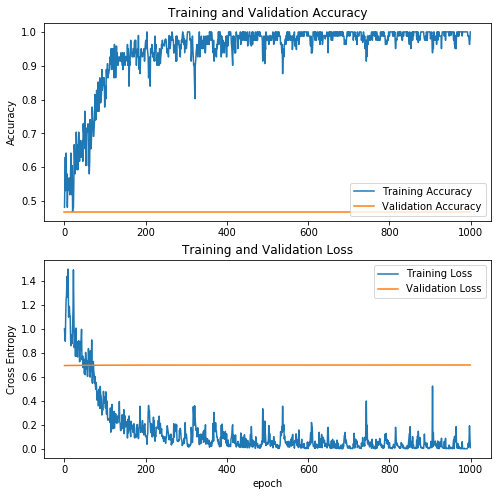

In [88]:
# plot training

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(output +'plot.pdf') as pdf:
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    pdf.savefig();
    plt.show()
    plt.close()

In [89]:
#predict test_data

def probas_to_classes(y_pred):
    return np.array([1 if p > 0.5 else 0 for p in y_pred])

#create Image generator
datagen_test = ImageDataGenerator(
        rescale=1./255)  # set values to 0-1

#Note. not sure if these have to be reshuffled during iterations
#create generator for training data
test_generator = datagen_test.flow_from_dataframe(
        dataframe=df_test,
        x_col="filename",
        y_col="class",
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle = False,
        color_mode = 'grayscale' if CHANNELS == 1 else 'rgb' )

# run testdata
prediction = model.predict(test_generator)
pred_classes = probas_to_classes(prediction)

print(test_generator.class_indices)

for i in range(0,len(prediction)):
    pred_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(pred_classes[i])]
    print(test_filenames[i] + ' - ' + test_labels[i] + ' - ' + str(prediction[i])+ ' - pred: ' + pred_class)

Found 16 validated image filenames belonging to 2 classes.
{'CB': 0, 'UT': 1}
D:\work\48h_output\mean_backSub\015.png - CB - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\162.png - UT - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\220.png - UT - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\173.png - UT - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\177.png - UT - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\065.png - CB - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\018.png - CB - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\045.png - CB - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\036.png - CB - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\055.png - CB - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\153.png - UT - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\210.png - UT - [0.52521676] - pred: UT
D:\work\48h_output\mean_backSub\019.png - CB - [0.52521676] - pred: UT